# Reto Coppel


## Importación de librerías

In [55]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import boxcox, expon, weibull_min, gamma, lognorm, pareto, probplot, kstest, gaussian_kde
from distfit import distfit

## Carga de datos

In [4]:
retail = pd.read_csv("../dataset.csv")

Cambiemos los nombres de los atributos a un mismo formato.

In [5]:
retail.columns = retail.columns.str.capitalize()

Trabajaremos solo con los datos de retail debido a los recursos computacionales limitados y a que es el segmento más problemático.

In [6]:
retail = retail[retail['Segmento'] == "retail"]

## Inspección

In [7]:
retail.head()

,Unnamed: 0,Fecha,Segmento,Hora_llegada,Hora_llamado,Hora_salida,Caja,Tienda,Status,Estado
0,821243,2023-01-01,retail,0.503465,0.503477,0.503581,caja_a,Tienda_A,Atendido,Ciudad de México
1,821244,2023-01-01,retail,0.503581,0.503616,0.511174,caja_a,Tienda_A,Atendido,Ciudad de México
2,821245,2023-01-01,retail,0.503789,0.503801,0.505120,caja_b,Tienda_A,Atendido,Ciudad de México
3,821246,2023-01-01,retail,0.503847,0.505132,0.509333,caja_b,Tienda_A,Atendido,Ciudad de México
4,821247,2023-01-01,retail,0.503894,0.508072,0.509981,caja_c,Tienda_A,Atendido,Ciudad de México


In [8]:
retail.shape

(9987098, 10)

### Tipos de datos

In [9]:
retail.dtypes

Unnamed: 0        int64
Fecha            object
Segmento         object
Hora_llegada    float64
Hora_llamado    float64
Hora_salida     float64
Caja             object
Tienda           object
Status           object
Estado           object
dtype: object

El tipo de dato de cada atributo corresponde a la naturaleza del atributo excepto *Fecha*.

### Valores nulos

In [10]:
retail.isnull().sum()

Unnamed: 0      0
Fecha           0
Segmento        0
Hora_llegada    0
Hora_llamado    0
Hora_salida     0
Caja            0
Tienda          0
Status          0
Estado          0
dtype: int64

No hay valores nulos.

### Valores únicos

In [11]:
def imprimir_datos(datos):
    for dato in datos:
        print(dato)

Revisemos que los datos se hayan filtrado correctamente.

In [12]:
imprimir_datos(retail['Segmento'].unique())


retail


In [13]:
imprimir_datos(retail['Caja'].unique())

caja_a
caja_b
caja_c
caja_d
caja_e
caja_f
caja_j
caja_h
caja_i
caja_k
caja_l
caja_m
caja_n
ventanilla_b
caja_o
caja_p
caja_q
ventanilla_d
p_b
ventanilla_c
p_a
p_f
p_h
ventanilla_a
p_m
p_e
p_g
ventanilla_f
p_d
p_c
p_k
p_j
p_i
ventanilla_e
ventanilla_g
p_n
caja_r
caja_s
caja_t
caja_u
caja_v
Caja_a
Caja_b
Caja_c
Caja_d
Caja_e
p_t
p_u
Caja_f
p_v
ventanilla_m
ventanilla_k
ventanilla_o
ventanilla_l
ventanilla_p
p_o
p_q
p_s
ventanilla_j
ventanilla_i
p_p
ventanilla_n
ventanilla_h
ventanilla_s
P_b
ventanilla_r
p_r
p_y
caja_x
p_z
P_c
P_a
p_l
a_a


Se tienen 74 cajas distintas que se dividen en tres tipos: caja, ventanilla, p. Hay errores de etiquetado.

In [14]:
imprimir_datos(retail['Tienda'].unique())

Tienda_A
Tienda_B
Tienda_C
Tienda_D
Tienda_E
Tienda_F
Tienda_G
Tienda_H
Tienda_I
Tienda_J
Tienda_K
Tienda_L
Tienda_M
Tienda_N
Tienda_O
Tienda_P
Tienda_Q
Tienda_R
Tienda_S
Tienda_T
Tienda_U
Tienda_X
Tienda_Y
Tienda_Z
Tienda_V
Tienda_AB
Tienda_AC
Tienda_AE
Tienda_AF
Tienda_AG
Tienda_AH
Tienda_AI
Tienda_AJ
Tienda_AK
Tienda_AA
Tienda_AL
Tienda_AM
Tienda_AN
Tienda_AO
Tienda_AP
Tienda_AQ
Tienda_AX
Tienda_AD
Tienda_AY
Tienda_AZ
Tienda_BA
Tienda_BB
Tienda_BC
Tienda_BD
Tienda_BE


Se tienen 50 tiendas distintas.

In [15]:
imprimir_datos(retail['Status'].unique())

Atendido
Ausente


In [16]:
imprimir_datos(retail['Estado'].unique())

Ciudad de México
Quintana Roo
Sonora
Sinaloa
Veracruz de Ignacio de la Llave
Chiapas
Puebla
Tabasco
Durango
Yucatán
Guanajuato
Chihuahua
Zacatecas
México
Oaxaca
Morelos
Nuevo León
Querétaro
Michoacán de Ocampo
Guerrero
Baja California
Baja California Sur
Coahuila de Zaragoza


Se incluyen solo 23 estados de la república.

Comentario: hay errores de etiquetado en el atributo *Caja*.

## Limpieza de datos

### Errores de tipo de dato

In [17]:
retail['Fecha'] = pd.to_datetime(retail['Fecha'])

### Errores de etiquetado

Corrijamos errores de etiquetado, en este caso, cambiemos todos los valores del atributo *Caja* a minusculas para que no haya valores repetidos que se identifiquen como distintos por el uso de mayusculas.

In [18]:
retail['retail'] = retail['Caja'].str.lower()

### Ruido

Eliminemos las observaciones donde la hora de llegada es mayor que la hora de llamado o salida y las observaciones donde su hora de llamado es mayor al horario de salida

In [19]:
retail = retail[(retail['Hora_llegada'] < retail['Hora_llamado']) &
        (retail['Hora_llegada'] < retail['Hora_salida']) &
        (retail['Hora_llamado'] < retail['Hora_salida'])]
retail.shape[0]

9734454

Se eliminaron 250,000 observaciones, aproximadamente.

## Creación de nuevas columnas

Separemos el atributo compuesto *Fecha* en tres atributos: *Dia*, *Mes* y *Anio*.

In [20]:

retail['Anio'] = retail['Fecha'].dt.year  # Extraer el año
retail['Mes'] = retail['Fecha'].dt.month  # Extraer el mes
retail['Dia'] = retail['Fecha'].dt.day


In [21]:
imprimir_datos(retail['Anio'].unique())

2023
2024


In [22]:
imprimir_datos(retail['Mes'].unique())

1
2
3
4
5
6
7
8
9
10
11
12


In [23]:
imprimir_datos(retail['Dia'].unique())

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


In [24]:
retail['Dia_semana'] = retail['Fecha'].dt.dayofweek

In [25]:
imprimir_datos(retail['Dia_semana'].unique())

6
0
1
2
3
4
5


Creemos una nueva columna que sea la diferencia de los atributos *Hora_llamado* y *Hora_llegada* para su posterior análisis.

In [26]:
retail['Tiempo_espera'] = retail['Hora_llamado'] - retail['Hora_llegada']
retail.head()

In [27]:
retail.head()

,Unnamed: 0,Fecha,Segmento,Hora_llegada,Hora_llamado,Hora_salida,Caja,Tienda,Status,Estado,retail,Anio,Mes,Dia,Dia_semana,Tiempo_espera
0,821243,2023-01-01,retail,0.503465,0.503477,0.503581,caja_a,Tienda_A,Atendido,Ciudad de México,caja_a,2023,1,1,6,0.000012
1,821244,2023-01-01,retail,0.503581,0.503616,0.511174,caja_a,Tienda_A,Atendido,Ciudad de México,caja_a,2023,1,1,6,0.000035
2,821245,2023-01-01,retail,0.503789,0.503801,0.505120,caja_b,Tienda_A,Atendido,Ciudad de México,caja_b,2023,1,1,6,0.000012
3,821246,2023-01-01,retail,0.503847,0.505132,0.509333,caja_b,Tienda_A,Atendido,Ciudad de México,caja_b,2023,1,1,6,0.001285
4,821247,2023-01-01,retail,0.503894,0.508072,0.509981,caja_c,Tienda_A,Atendido,Ciudad de México,caja_c,2023,1,1,6,0.004178


Creemos un atributo que contenga el número de cajas abiertas en el día.

In [77]:
numero_cajas = retail.groupby(['Fecha'])['Fecha'].count().reset_index(name='Cajas abiertas')
retail.merge(numero_cajas, how='left', on='Fecha')

,Unnamed: 0,Fecha,Segmento,Hora_llegada,Hora_llamado,Hora_salida,Caja,Tienda,Status,Estado,retail,Anio,Mes,Dia,Dia_semana,Tiempo_espera,Cajas abiertas
0,821243,2023-01-01,retail,0.503465,0.503477,0.503581,caja_a,Tienda_A,Atendido,Ciudad de México,caja_a,2023,1,1,6,0.000012,448
1,821244,2023-01-01,retail,0.503581,0.503616,0.511174,caja_a,Tienda_A,Atendido,Ciudad de México,caja_a,2023,1,1,6,0.000035,448
2,821245,2023-01-01,retail,0.503789,0.503801,0.505120,caja_b,Tienda_A,Atendido,Ciudad de México,caja_b,2023,1,1,6,0.000012,448
3,821246,2023-01-01,retail,0.503847,0.505132,0.509333,caja_b,Tienda_A,Atendido,Ciudad de México,caja_b,2023,1,1,6,0.001285,448
4,821247,2023-01-01,retail,0.503894,0.508072,0.509981,caja_c,Tienda_A,Atendido,Ciudad de México,caja_c,2023,1,1,6,0.004178,448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9734449,18395851,2024-01-31,retail,0.891324,0.892493,0.893720,caja_h,Tienda_B,Atendido,Quintana Roo,caja_h,2024,1,31,2,0.001169,24894
9734450,18395852,2024-01-31,retail,0.891590,0.893280,0.920560,caja_b,Tienda_B,Atendido,Quintana Roo,caja_b,2024,1,31,2,0.001690,24894
9734451,18395854,2024-01-31,retail,0.893130,0.893743,0.894843,caja_h,Tienda_B,Atendido,Quintana Roo,caja_h,2024,1,31,2,0.000613,24894
9734452,18395855,2024-01-31,retail,0.893523,0.894854,0.895722,caja_h,Tienda_B,Atendido,Quintana Roo,caja_h,2024,1,31,2,0.001331,24894


## Análisis exploratorio de datos

Hagamos un análisis exploratorio por tienda.

In [28]:
retail_por_tienda = dict()
count = 0
for tienda in retail['Tienda'].unique():
    retail_por_tienda[tienda] = retail[retail['Tienda'] == tienda]

Dejamos de lado el atributo *Estado*, ya que no sería necesario si analizaremos los datos por tienda.

In [29]:
def EDA(retail_por_tienda):
    for tienda, conjunto_datos in retail_por_tienda.items():
        print(tienda)
        print("Tiempos de espera")
        print(conjunto_datos['Tiempo_espera'].describe())
        plt.hist(conjunto_datos.Tiempo_espera, bins=50)
        plt.show()
        print("Tiempos de espera por status")
        atendido = conjunto_datos.loc[conjunto_datos.Status == "Atendido", "Tiempo_espera"]
        ausente = conjunto_datos.loc[conjunto_datos.Status == "Ausente", "Tiempo_espera"]
        print(atendido.describe())
        print(ausente.describe())
        plt.hist(atendido, bins=50, density=True)
        plt.hist(ausente, bins=50, density=True, alpha=0.75)
        plt.show()
        print("---------------------------------------")


Tienda_A
Tiempos de espera
count    275357.000000
mean          0.002768
std           0.004437
min           0.000012
25%           0.000463
50%           0.001655
75%           0.003530
max           0.330394
Name: Tiempo_espera, dtype: float64


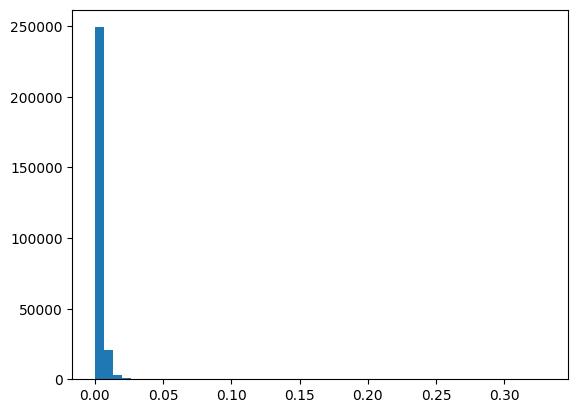

Tiempos de espera por status
count    264454.000000
mean          0.002665
std           0.003948
min           0.000012
25%           0.000440
50%           0.001609
75%           0.003438
max           0.154525
Name: Tiempo_espera, dtype: float64
count    10903.000000
mean         0.005261
std          0.010620
min          0.000012
25%          0.001204
50%          0.002789
75%          0.005694
max          0.330394
Name: Tiempo_espera, dtype: float64


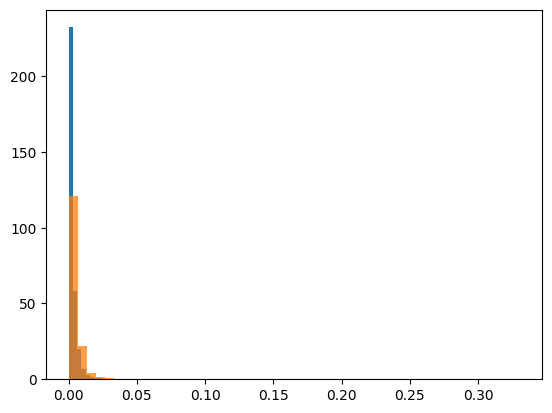

---------------------------------------
Tienda_B
Tiempos de espera
count    222114.000000
mean          0.001381
std           0.003299
min           0.000012
25%           0.000046
50%           0.000532
75%           0.001690
max           0.237060
Name: Tiempo_espera, dtype: float64


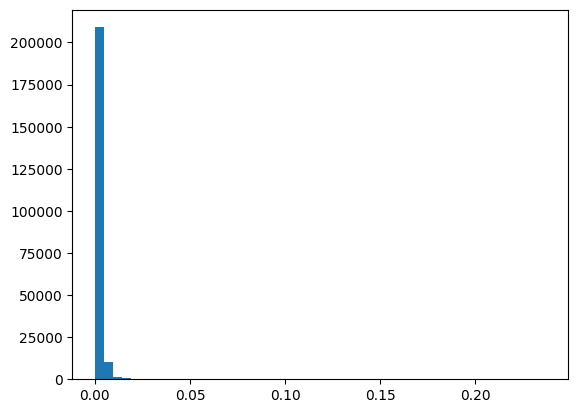

Tiempos de espera por status
count    218686.000000
mean          0.001346
std           0.003102
min           0.000012
25%           0.000046
50%           0.000521
75%           0.001667
max           0.237060
Name: Tiempo_espera, dtype: float64
count    3428.000000
mean        0.003626
std         0.009295
min         0.000012
25%         0.000440
50%         0.001447
75%         0.003623
max         0.212755
Name: Tiempo_espera, dtype: float64


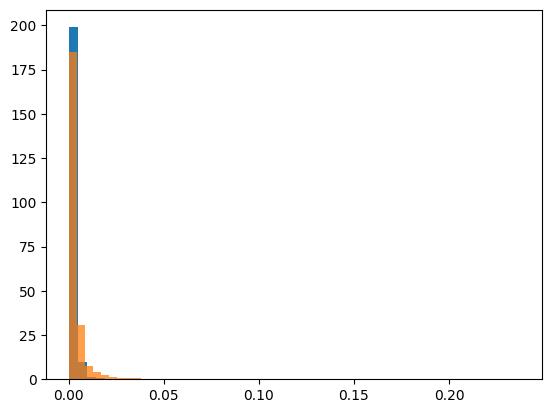

---------------------------------------
Tienda_C
Tiempos de espera
count    84107.000000
mean         0.002873
std          0.012436
min          0.000012
25%          0.000093
50%          0.001019
75%          0.002731
max          0.355556
Name: Tiempo_espera, dtype: float64


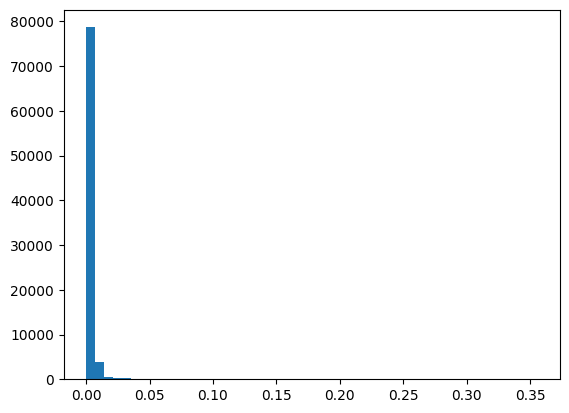

Tiempos de espera por status
count    69402.000000
mean         0.002762
std          0.013332
min          0.000012
25%          0.000058
50%          0.000880
75%          0.002512
max          0.355556
Name: Tiempo_espera, dtype: float64
count    14705.000000
mean         0.003394
std          0.006729
min          0.000012
25%          0.000440
50%          0.001782
75%          0.003889
max          0.140660
Name: Tiempo_espera, dtype: float64


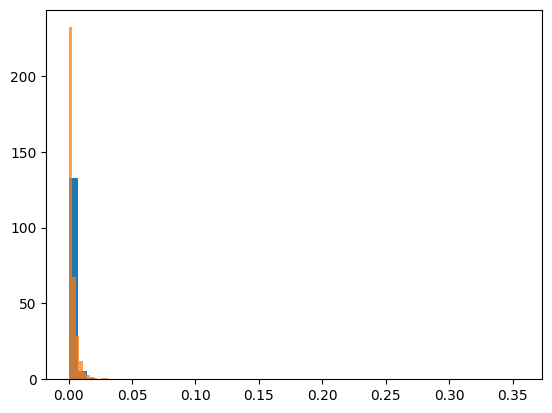

---------------------------------------
Tienda_D
Tiempos de espera
count    131898.000000
mean          0.001552
std           0.004854
min           0.000012
25%           0.000046
50%           0.000451
75%           0.001771
max           0.225208
Name: Tiempo_espera, dtype: float64


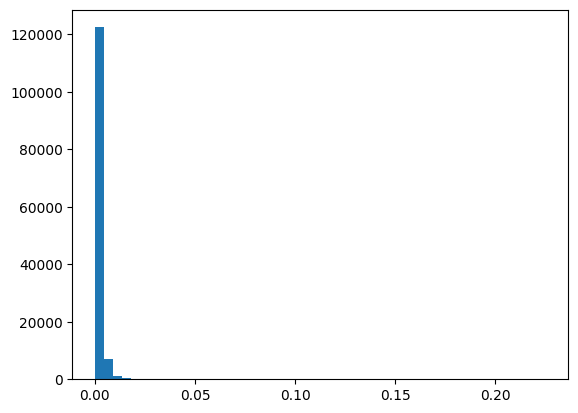

Tiempos de espera por status
count    127924.000000
mean          0.001463
std           0.004535
min           0.000012
25%           0.000046
50%           0.000428
75%           0.001725
max           0.180590
Name: Tiempo_espera, dtype: float64
count    3974.000000
mean        0.004406
std         0.010571
min         0.000012
25%         0.000162
50%         0.001354
75%         0.003877
max         0.225208
Name: Tiempo_espera, dtype: float64


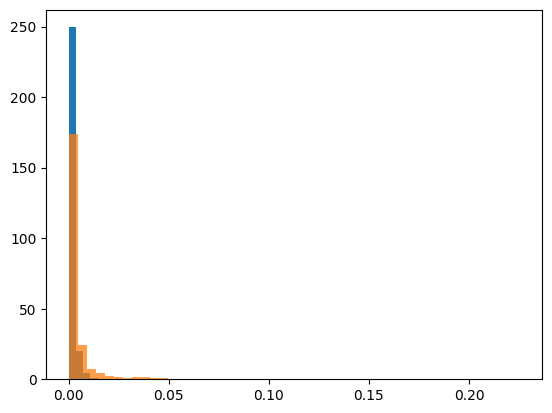

---------------------------------------
Tienda_E
Tiempos de espera
count    157383.000000
mean          0.001325
std           0.005193
min           0.000012
25%           0.000035
50%           0.000208
75%           0.001366
max           0.387037
Name: Tiempo_espera, dtype: float64


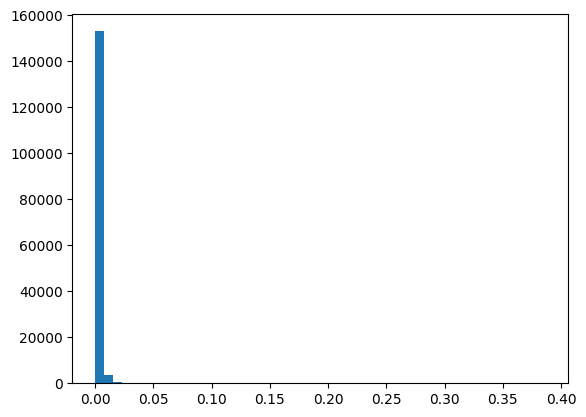

Tiempos de espera por status
count    144590.000000
mean          0.001198
std           0.004608
min           0.000012
25%           0.000035
50%           0.000162
75%           0.001250
max           0.387037
Name: Tiempo_espera, dtype: float64
count    12793.000000
mean         0.002754
std          0.009463
min          0.000012
25%          0.000058
50%          0.000937
75%          0.002789
max          0.377604
Name: Tiempo_espera, dtype: float64


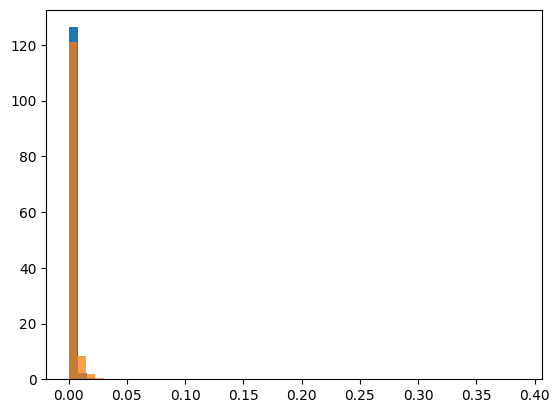

---------------------------------------
Tienda_F
Tiempos de espera
count    152090.000000
mean          0.002520
std           0.005317
min           0.000012
25%           0.000058
50%           0.000961
75%           0.002917
max           0.355451
Name: Tiempo_espera, dtype: float64


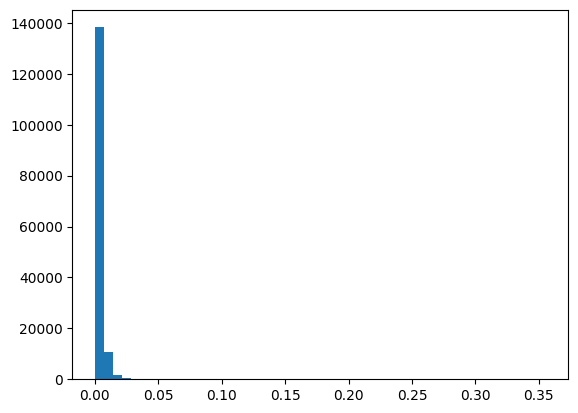

Tiempos de espera por status
count    143509.000000
mean          0.002297
std           0.004500
min           0.000012
25%           0.000046
50%           0.000880
75%           0.002743
max           0.355243
Name: Tiempo_espera, dtype: float64
count    8581.000000
mean        0.006234
std         0.012160
min         0.000012
25%         0.000880
50%         0.002697
75%         0.007153
max         0.355451
Name: Tiempo_espera, dtype: float64


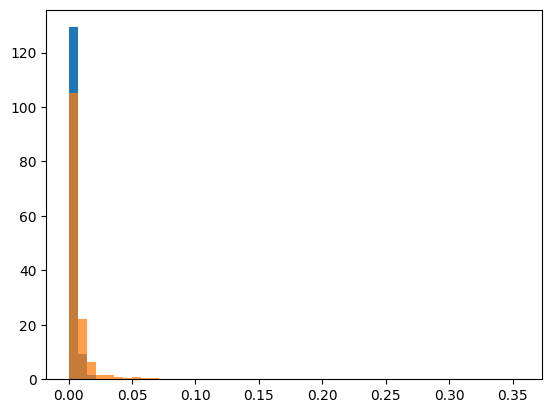

---------------------------------------
Tienda_G
Tiempos de espera
count    237528.000000
mean          0.003766
std           0.005377
min           0.000012
25%           0.000637
50%           0.002118
75%           0.005069
max           0.385683
Name: Tiempo_espera, dtype: float64


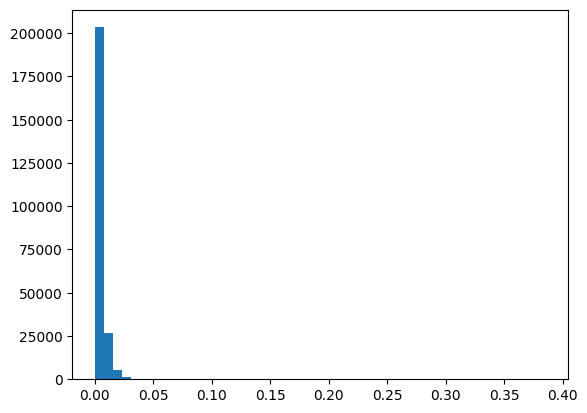

Tiempos de espera por status
count    222554.000000
mean          0.003612
std           0.005224
min           0.000012
25%           0.000590
50%           0.002049
75%           0.004815
max           0.385683
Name: Tiempo_espera, dtype: float64
count    14974.000000
mean         0.006056
std          0.006896
min          0.000012
25%          0.001597
50%          0.004016
75%          0.008750
max          0.237836
Name: Tiempo_espera, dtype: float64


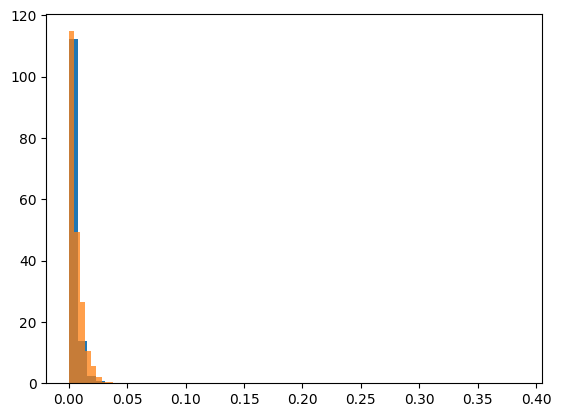

---------------------------------------
Tienda_H
Tiempos de espera
count    224465.000000
mean          0.001965
std           0.005107
min           0.000012
25%           0.000058
50%           0.000822
75%           0.002303
max           0.274618
Name: Tiempo_espera, dtype: float64


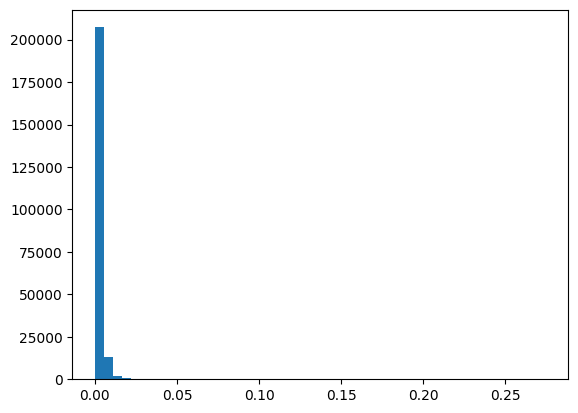

Tiempos de espera por status
count    211510.000000
mean          0.001870
std           0.005001
min           0.000012
25%           0.000058
50%           0.000764
75%           0.002211
max           0.274618
Name: Tiempo_espera, dtype: float64
count    12955.000000
mean         0.003516
std          0.006406
min          0.000012
25%          0.000683
50%          0.001944
75%          0.004236
max          0.227928
Name: Tiempo_espera, dtype: float64


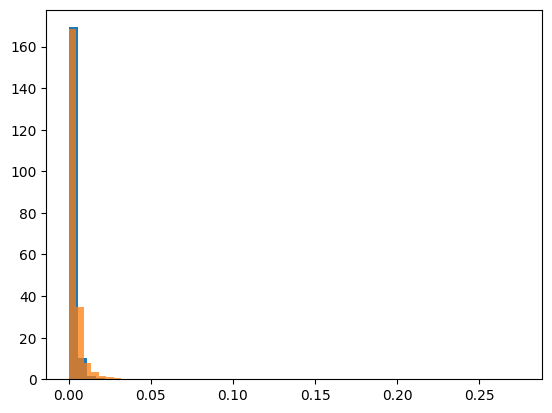

---------------------------------------
Tienda_I
Tiempos de espera
count    170803.000000
mean          0.002604
std           0.004863
min           0.000012
25%           0.000174
50%           0.001366
75%           0.003472
max           0.278171
Name: Tiempo_espera, dtype: float64


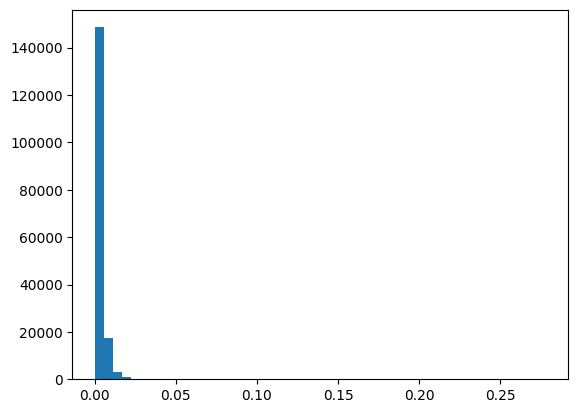

Tiempos de espera por status
count    168764.000000
mean          0.002585
std           0.004790
min           0.000012
25%           0.000174
50%           0.001354
75%           0.003461
max           0.278171
Name: Tiempo_espera, dtype: float64
count    2039.000000
mean        0.004219
std         0.008878
min         0.000012
25%         0.000637
50%         0.002350
75%         0.005231
max         0.176655
Name: Tiempo_espera, dtype: float64


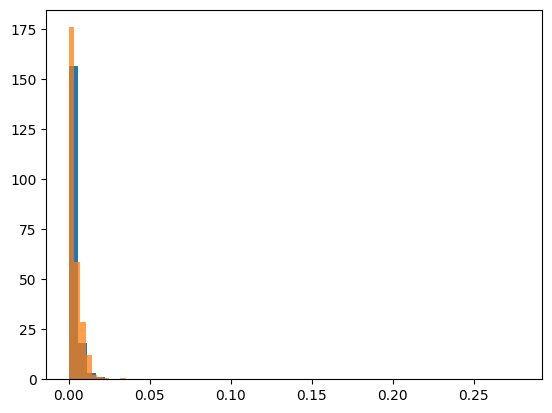

---------------------------------------
Tienda_J
Tiempos de espera
count    165695.000000
mean          0.002461
std           0.004966
min           0.000012
25%           0.000440
50%           0.001516
75%           0.003194
max           0.265475
Name: Tiempo_espera, dtype: float64


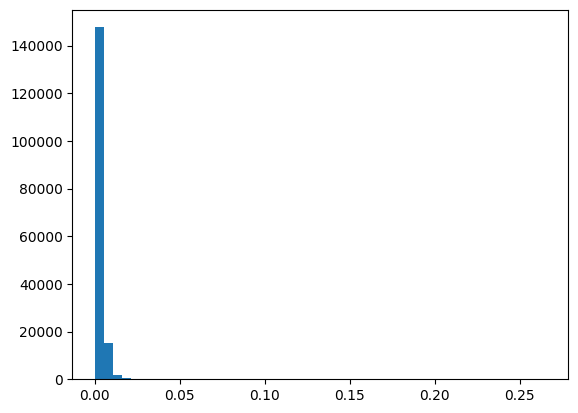

Tiempos de espera por status
count    148997.000000
mean          0.002282
std           0.004921
min           0.000012
25%           0.000370
50%           0.001377
75%           0.002963
max           0.265475
Name: Tiempo_espera, dtype: float64
count    16698.000000
mean         0.004056
std          0.005073
min          0.000012
25%          0.001539
50%          0.002986
75%          0.005301
max          0.218796
Name: Tiempo_espera, dtype: float64


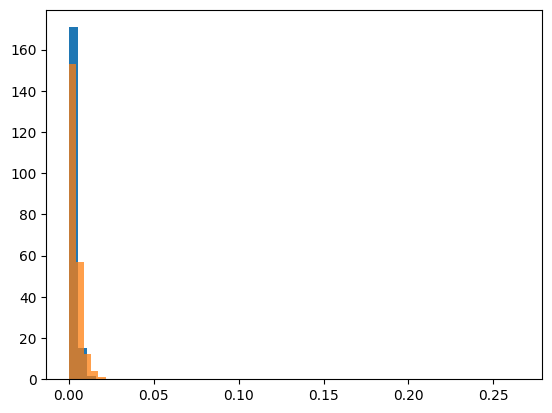

---------------------------------------
Tienda_K
Tiempos de espera
count    194359.000000
mean          0.004648
std           0.009290
min           0.000012
25%           0.001181
50%           0.002708
75%           0.005729
max           0.390775
Name: Tiempo_espera, dtype: float64


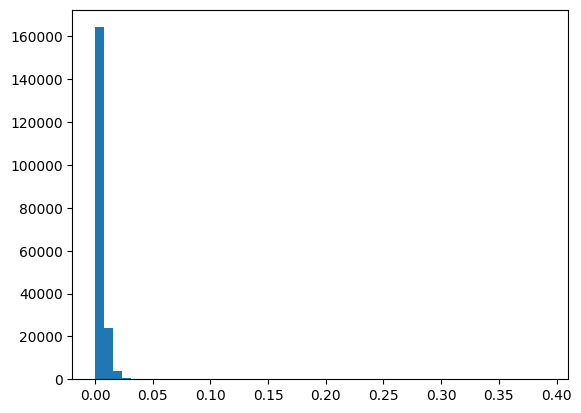

Tiempos de espera por status
count    181302.000000
mean          0.004488
std           0.009324
min           0.000012
25%           0.001146
50%           0.002627
75%           0.005521
max           0.390775
Name: Tiempo_espera, dtype: float64
count    13057.000000
mean         0.006878
std          0.008485
min          0.000012
25%          0.001991
50%          0.004606
75%          0.009132
max          0.142894
Name: Tiempo_espera, dtype: float64


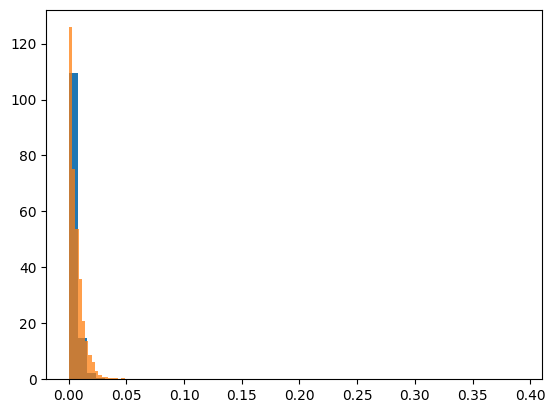

---------------------------------------
Tienda_L
Tiempos de espera
count    185076.000000
mean          0.002525
std           0.006315
min           0.000012
25%           0.000289
50%           0.001169
75%           0.002986
max           0.402211
Name: Tiempo_espera, dtype: float64


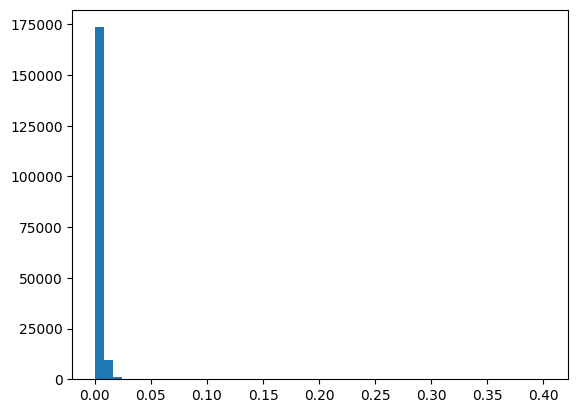

Tiempos de espera por status
count    183993.000000
mean          0.002505
std           0.006218
min           0.000012
25%           0.000289
50%           0.001157
75%           0.002975
max           0.402211
Name: Tiempo_espera, dtype: float64
count    1083.000000
mean        0.005834
std         0.015337
min         0.000012
25%         0.001256
50%         0.003044
75%         0.006765
max         0.256968
Name: Tiempo_espera, dtype: float64


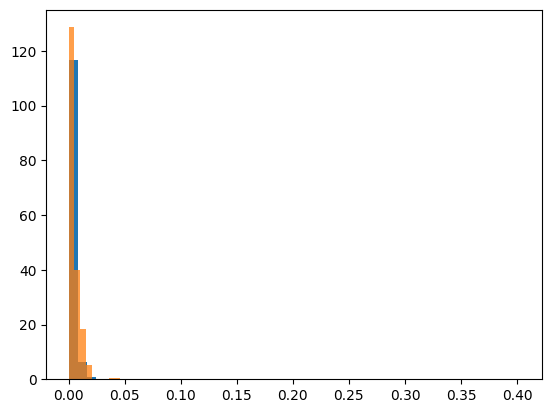

---------------------------------------
Tienda_M
Tiempos de espera
count    338987.000000
mean          0.003047
std           0.005336
min           0.000012
25%           0.000347
50%           0.001505
75%           0.003796
max           0.282442
Name: Tiempo_espera, dtype: float64


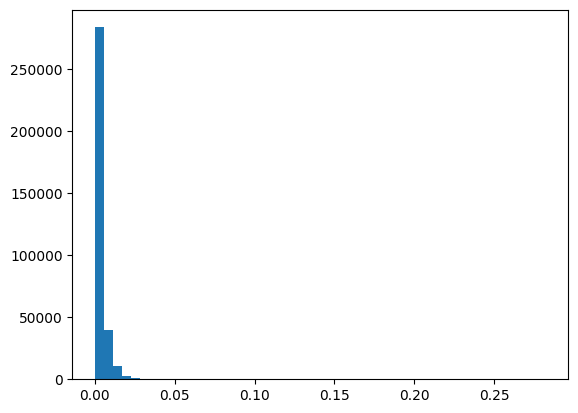

Tiempos de espera por status
count    325287.000000
mean          0.002923
std           0.005206
min           0.000012
25%           0.000324
50%           0.001447
75%           0.003623
max           0.208866
Name: Tiempo_espera, dtype: float64
count    13700.000000
mean         0.005988
std          0.007203
min          0.000012
25%          0.001319
50%          0.003808
75%          0.008970
max          0.282442
Name: Tiempo_espera, dtype: float64


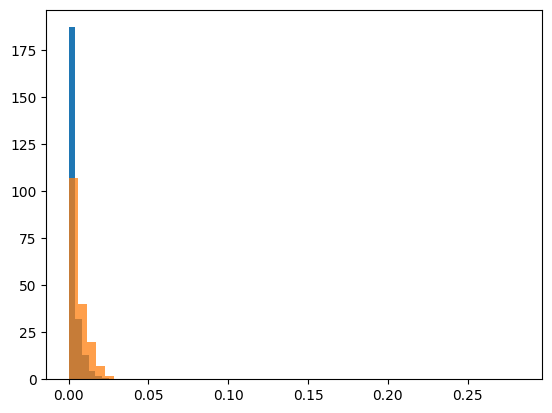

---------------------------------------
Tienda_N
Tiempos de espera
count    165642.000000
mean          0.003165
std           0.006026
min           0.000012
25%           0.000521
50%           0.001863
75%           0.004236
max           0.309109
Name: Tiempo_espera, dtype: float64


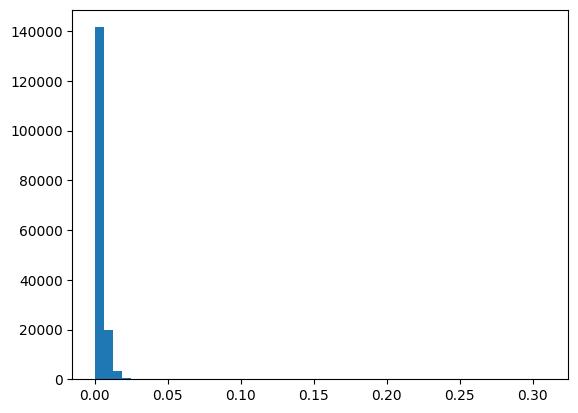

Tiempos de espera por status
count    156879.000000
mean          0.002940
std           0.004453
min           0.000012
25%           0.000486
50%           0.001782
75%           0.004074
max           0.214630
Name: Tiempo_espera, dtype: float64
count    8763.000000
mean        0.007200
std         0.017724
min         0.000012
25%         0.001609
50%         0.003553
75%         0.007159
max         0.309109
Name: Tiempo_espera, dtype: float64


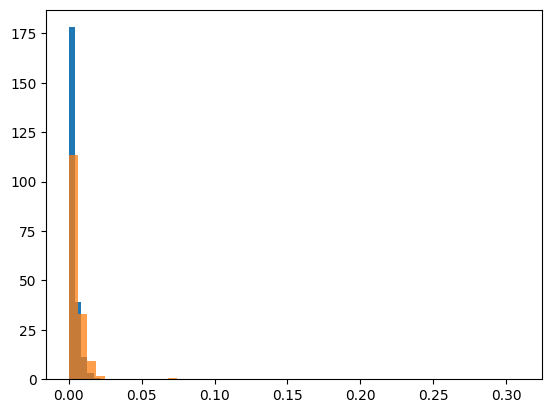

---------------------------------------
Tienda_O
Tiempos de espera
count    165955.000000
mean          0.002192
std           0.003778
min           0.000012
25%           0.000046
50%           0.000833
75%           0.002917
max           0.254850
Name: Tiempo_espera, dtype: float64


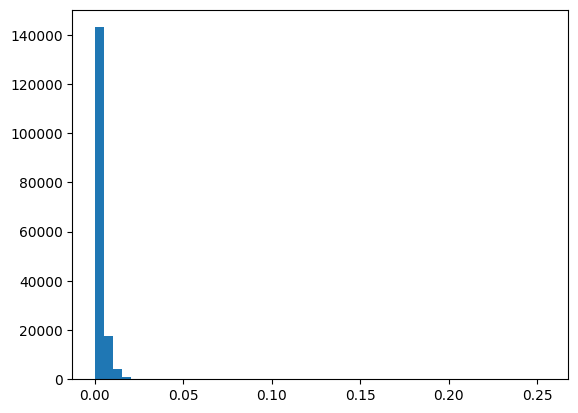

Tiempos de espera por status
count    164531.000000
mean          0.002164
std           0.003737
min           0.000012
25%           0.000046
50%           0.000810
75%           0.002882
max           0.254850
Name: Tiempo_espera, dtype: float64
count    1424.000000
mean        0.005422
std         0.006230
min         0.000012
25%         0.001435
50%         0.003924
75%         0.007613
max         0.123449
Name: Tiempo_espera, dtype: float64


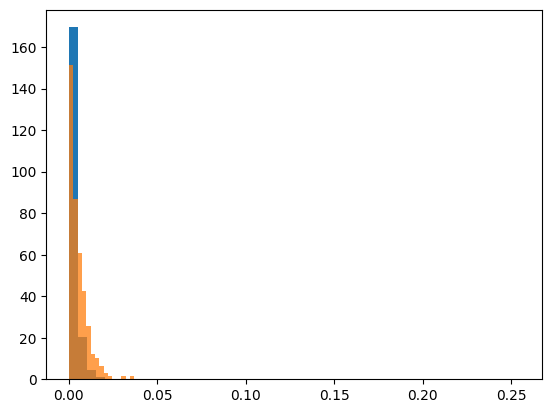

---------------------------------------
Tienda_Q
Tiempos de espera
count    142301.000000
mean          0.003611
std           0.007802
min           0.000012
25%           0.000764
50%           0.002060
75%           0.004132
max           0.355243
Name: Tiempo_espera, dtype: float64


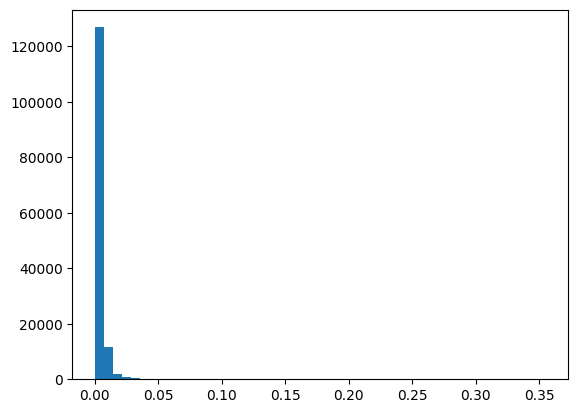

Tiempos de espera por status
count    129438.000000
mean          0.003109
std           0.005670
min           0.000012
25%           0.000694
50%           0.001944
75%           0.003796
max           0.355243
Name: Tiempo_espera, dtype: float64
count    12863.000000
mean         0.008662
std          0.017939
min          0.000012
25%          0.002037
50%          0.004016
75%          0.008027
max          0.194294
Name: Tiempo_espera, dtype: float64


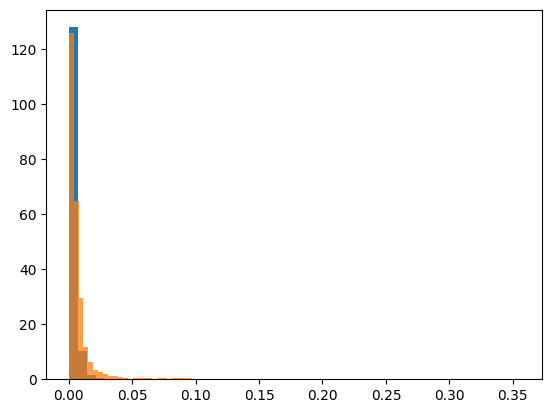

---------------------------------------
Tienda_P
Tiempos de espera
count    256763.000000
mean          0.005649
std           0.006695
min           0.000012
25%           0.001389
50%           0.003657
75%           0.007998
max           0.340694
Name: Tiempo_espera, dtype: float64


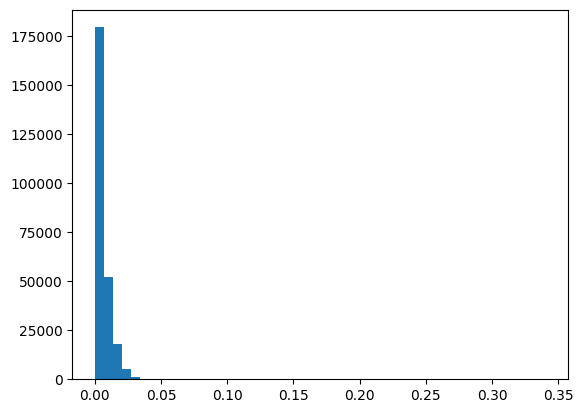

Tiempos de espera por status
count    242649.000000
mean          0.005414
std           0.006484
min           0.000012
25%           0.001331
50%           0.003495
75%           0.007639
max           0.340694
Name: Tiempo_espera, dtype: float64
count    14114.000000
mean         0.009690
std          0.008675
min          0.000012
25%          0.003391
50%          0.007951
75%          0.014051
max          0.303218
Name: Tiempo_espera, dtype: float64


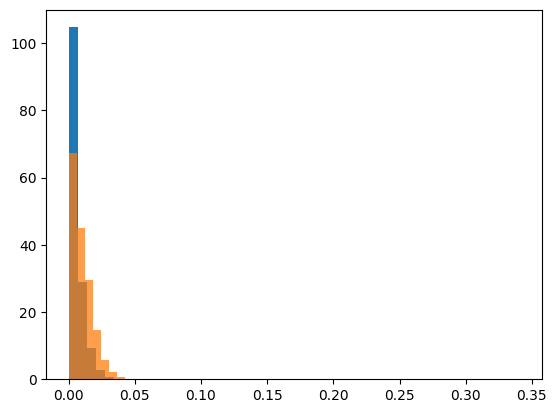

---------------------------------------
Tienda_R
Tiempos de espera
count    230347.000000
mean          0.004210
std           0.006575
min           0.000012
25%           0.000683
50%           0.002292
75%           0.005660
max           0.322095
Name: Tiempo_espera, dtype: float64


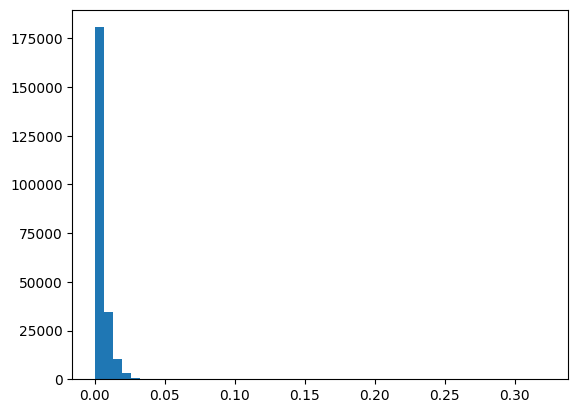

Tiempos de espera por status
count    214647.000000
mean          0.003870
std           0.005924
min           0.000012
25%           0.000625
50%           0.002153
75%           0.005266
max           0.322095
Name: Tiempo_espera, dtype: float64
count    15700.000000
mean         0.008870
std          0.011454
min          0.000012
25%          0.002303
50%          0.005937
75%          0.011863
max          0.273738
Name: Tiempo_espera, dtype: float64


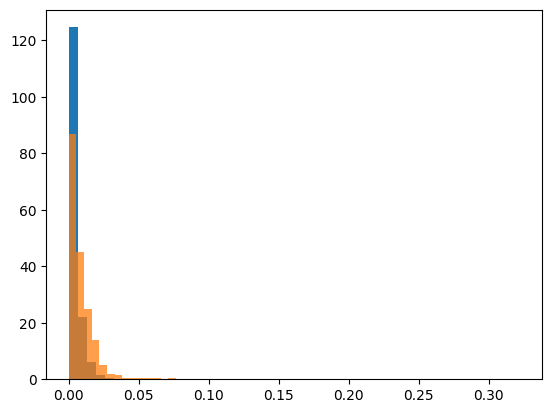

---------------------------------------
Tienda_S
Tiempos de espera
count    178981.000000
mean          0.006914
std           0.009551
min           0.000012
25%           0.001192
50%           0.004259
75%           0.009896
max           0.428958
Name: Tiempo_espera, dtype: float64


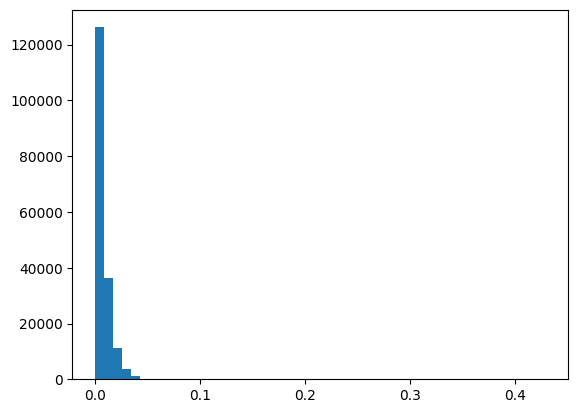

Tiempos de espera por status
count    165564.000000
mean          0.006276
std           0.008143
min           0.000012
25%           0.001065
50%           0.003900
75%           0.009144
max           0.428958
Name: Tiempo_espera, dtype: float64
count    13417.000000
mean         0.014782
std          0.018210
min          0.000012
25%          0.004850
50%          0.011528
75%          0.019352
max          0.279340
Name: Tiempo_espera, dtype: float64


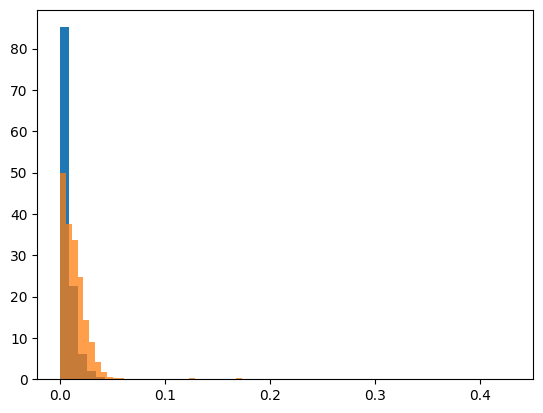

---------------------------------------
Tienda_T
Tiempos de espera
count    221590.000000
mean          0.003023
std           0.003772
min           0.000012
25%           0.000602
50%           0.001968
75%           0.004282
max           0.229549
Name: Tiempo_espera, dtype: float64


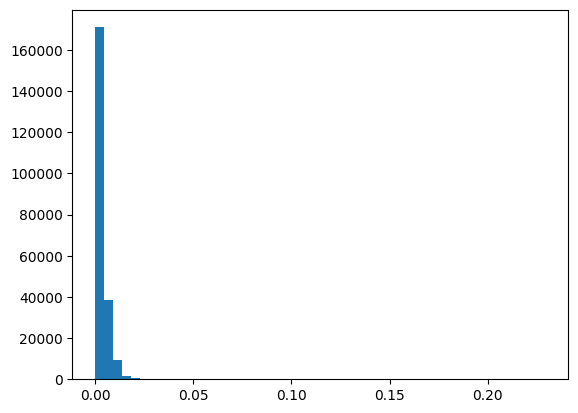

Tiempos de espera por status
count    218820.000000
mean          0.002989
std           0.003716
min           0.000012
25%           0.000602
50%           0.001944
75%           0.004248
max           0.229549
Name: Tiempo_espera, dtype: float64
count    2770.000000
mean        0.005741
std         0.006329
min         0.000012
25%         0.001863
50%         0.004213
75%         0.007708
max         0.091169
Name: Tiempo_espera, dtype: float64


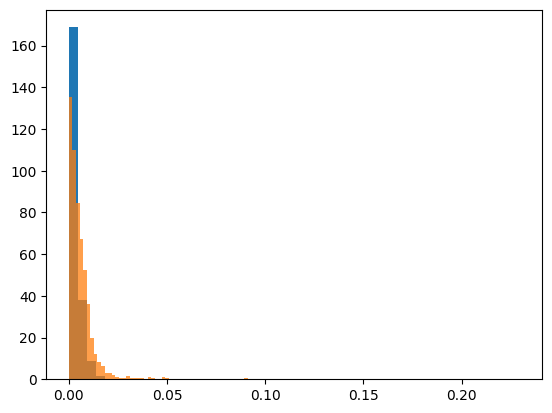

---------------------------------------
Tienda_U
Tiempos de espera
count    119748.000000
mean          0.002496
std           0.006519
min           0.000012
25%           0.000185
50%           0.001204
75%           0.002905
max           0.243981
Name: Tiempo_espera, dtype: float64


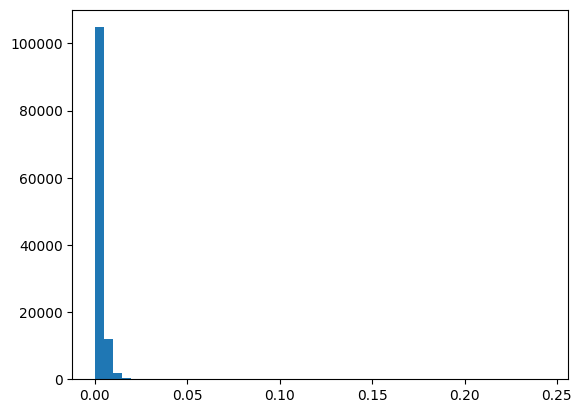

Tiempos de espera por status
count    115540.000000
mean          0.002432
std           0.006561
min           0.000012
25%           0.000162
50%           0.001157
75%           0.002812
max           0.243981
Name: Tiempo_espera, dtype: float64
count    4208.000000
mean        0.004271
std         0.004912
min         0.000012
25%         0.001424
50%         0.003090
75%         0.006021
max         0.118472
Name: Tiempo_espera, dtype: float64


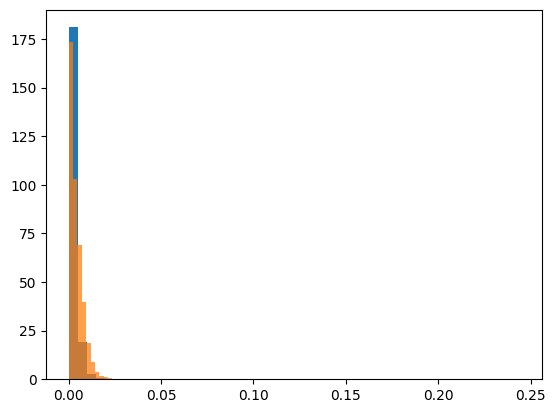

---------------------------------------
Tienda_X
Tiempos de espera
count    237407.000000
mean          0.001208
std           0.003262
min           0.000012
25%           0.000035
50%           0.000255
75%           0.001331
max           0.245521
Name: Tiempo_espera, dtype: float64


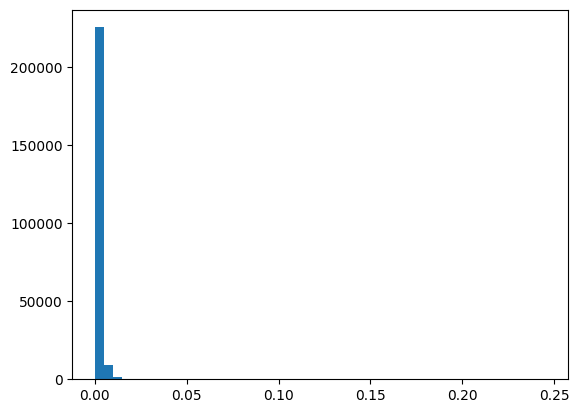

Tiempos de espera por status
count    231671.000000
mean          0.001159
std           0.003143
min           0.000012
25%           0.000035
50%           0.000231
75%           0.001296
max           0.245521
Name: Tiempo_espera, dtype: float64
count    5736.000000
mean        0.003189
std         0.006102
min         0.000012
25%         0.000278
50%         0.001354
75%         0.003484
max         0.132685
Name: Tiempo_espera, dtype: float64


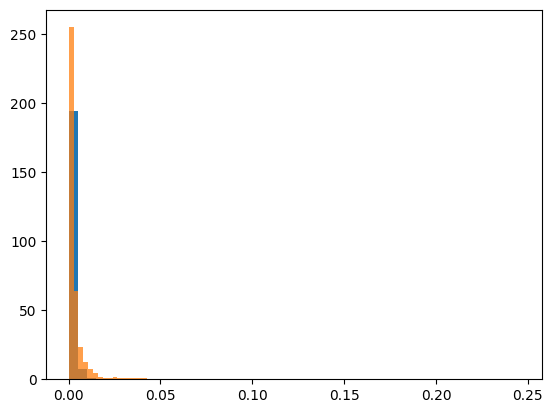

---------------------------------------
Tienda_Y
Tiempos de espera
count    161035.000000
mean          0.001563
std           0.004713
min           0.000012
25%           0.000046
50%           0.000671
75%           0.001956
max           0.329745
Name: Tiempo_espera, dtype: float64


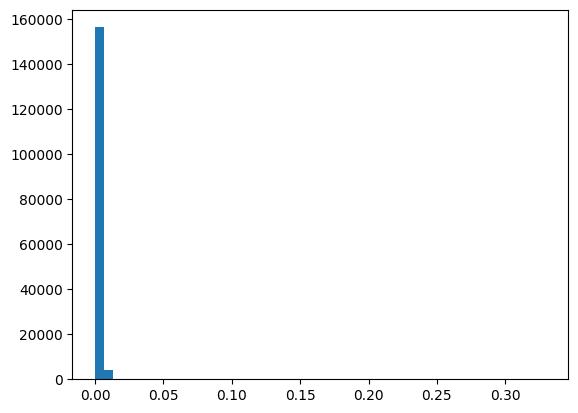

Tiempos de espera por status
count    158768.000000
mean          0.001537
std           0.004634
min           0.000012
25%           0.000046
50%           0.000660
75%           0.001944
max           0.329745
Name: Tiempo_espera, dtype: float64
count    2267.000000
mean        0.003417
std         0.008391
min         0.000012
25%         0.000613
50%         0.001736
75%         0.003848
max         0.199190
Name: Tiempo_espera, dtype: float64


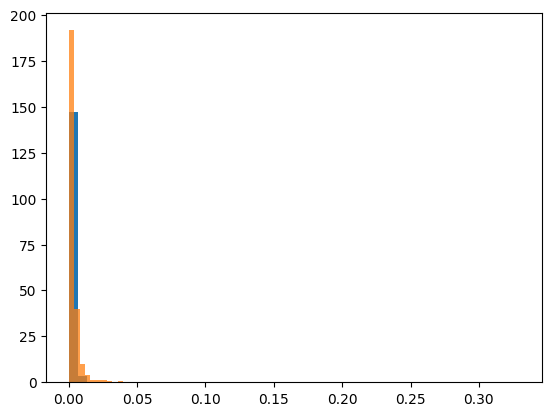

---------------------------------------
Tienda_Z
Tiempos de espera
count    189159.000000
mean          0.002197
std           0.004517
min           0.000012
25%           0.000162
50%           0.001042
75%           0.002836
max           0.274722
Name: Tiempo_espera, dtype: float64


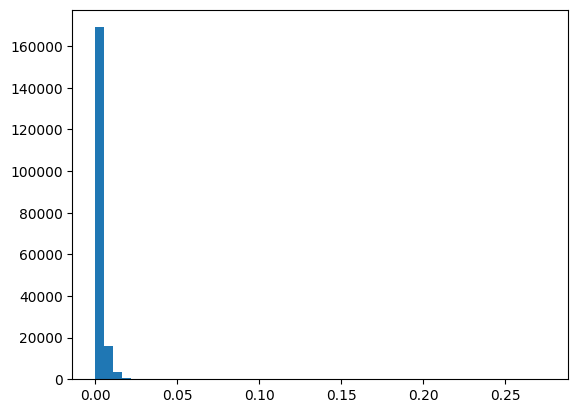

Tiempos de espera por status
count    188819.000000
mean          0.002184
std           0.004430
min           0.000012
25%           0.000162
50%           0.001030
75%           0.002824
max           0.274722
Name: Tiempo_espera, dtype: float64
count    340.000000
mean       0.009337
std        0.020090
min        0.000012
25%        0.001907
50%        0.005492
75%        0.010069
max        0.173449
Name: Tiempo_espera, dtype: float64


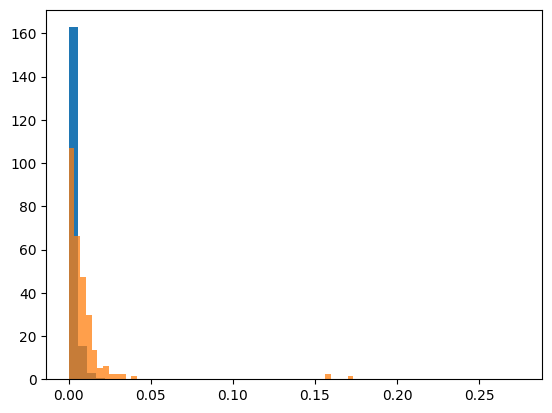

---------------------------------------
Tienda_V
Tiempos de espera
count    241276.000000
mean          0.006187
std           0.007702
min           0.000012
25%           0.001354
50%           0.003738
75%           0.008310
max           0.259363
Name: Tiempo_espera, dtype: float64


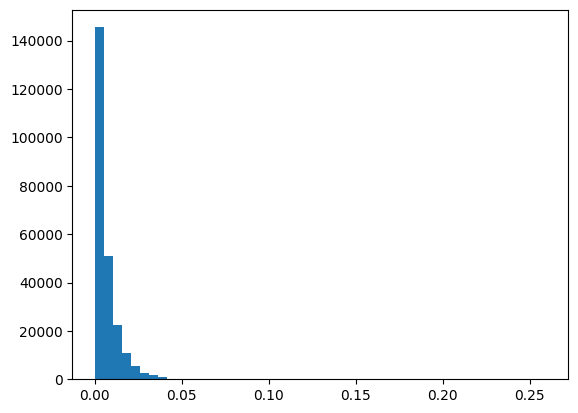

Tiempos de espera por status
count    218440.000000
mean          0.005773
std           0.007335
min           0.000012
25%           0.001250
50%           0.003519
75%           0.007766
max           0.259363
Name: Tiempo_espera, dtype: float64
count    22836.000000
mean         0.010153
std          0.009738
min          0.000012
25%          0.002778
50%          0.007020
75%          0.014595
max          0.113009
Name: Tiempo_espera, dtype: float64


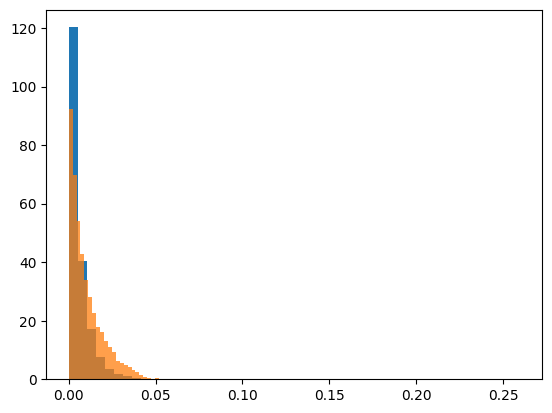

---------------------------------------
Tienda_AB
Tiempos de espera
count    224311.000000
mean          0.004167
std           0.006950
min           0.000012
25%           0.000336
50%           0.001898
75%           0.005428
max           0.364572
Name: Tiempo_espera, dtype: float64


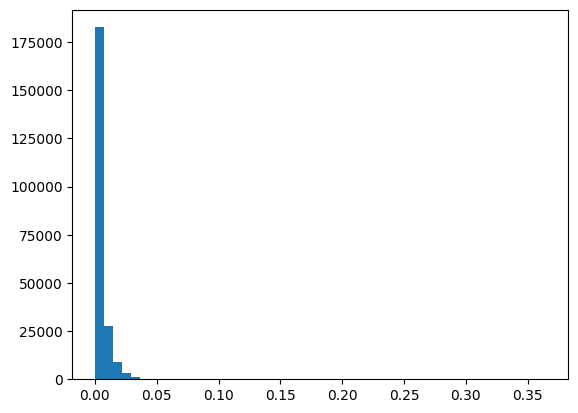

Tiempos de espera por status
count    215146.000000
mean          0.003885
std           0.006407
min           0.000012
25%           0.000301
50%           0.001782
75%           0.005046
max           0.364572
Name: Tiempo_espera, dtype: float64
count    9165.000000
mean        0.010808
std         0.013137
min         0.000012
25%         0.002917
50%         0.008449
75%         0.015752
max         0.301956
Name: Tiempo_espera, dtype: float64


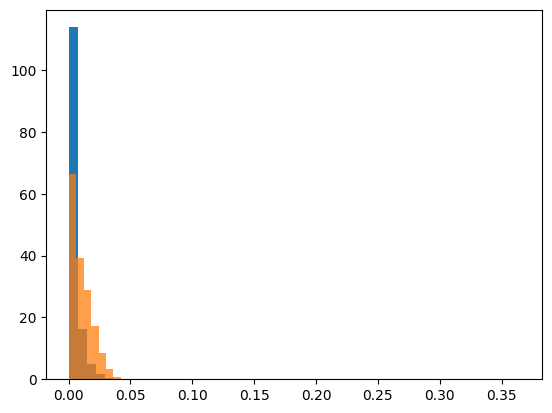

---------------------------------------
Tienda_AE
Tiempos de espera
count    228607.000000
mean          0.003399
std           0.005993
min           0.000012
25%           0.000509
50%           0.002014
75%           0.004676
max           0.396921
Name: Tiempo_espera, dtype: float64


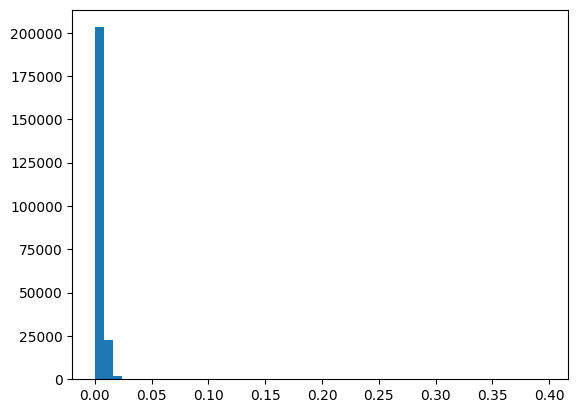

Tiempos de espera por status
count    216163.000000
mean          0.003248
std           0.005625
min           0.000012
25%           0.000475
50%           0.001933
75%           0.004479
max           0.396921
Name: Tiempo_espera, dtype: float64
count    12444.000000
mean         0.006025
std          0.010148
min          0.000012
25%          0.001644
50%          0.004028
75%          0.008160
max          0.264850
Name: Tiempo_espera, dtype: float64


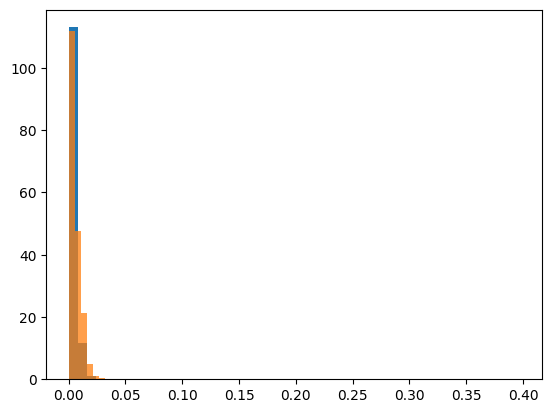

---------------------------------------
Tienda_AC
Tiempos de espera
count    185453.000000
mean          0.001794
std           0.003943
min           0.000012
25%           0.000081
50%           0.000845
75%           0.002326
max           0.123519
Name: Tiempo_espera, dtype: float64


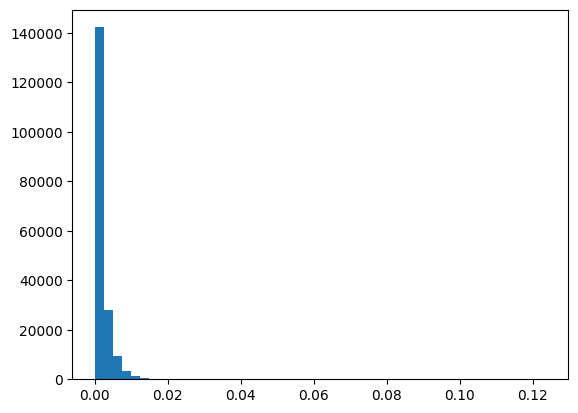

Tiempos de espera por status
count    175818.000000
mean          0.001626
std           0.003105
min           0.000012
25%           0.000058
50%           0.000787
75%           0.002211
max           0.120405
Name: Tiempo_espera, dtype: float64
count    9635.000000
mean        0.004863
std         0.010649
min         0.000012
25%         0.000903
50%         0.002280
75%         0.004873
max         0.123519
Name: Tiempo_espera, dtype: float64


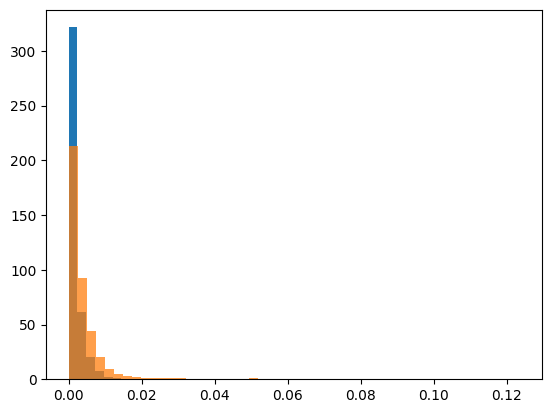

---------------------------------------
Tienda_AF
Tiempos de espera
count    168243.000000
mean          0.003484
std           0.006601
min           0.000012
25%           0.000556
50%           0.001875
75%           0.004201
max           0.257025
Name: Tiempo_espera, dtype: float64


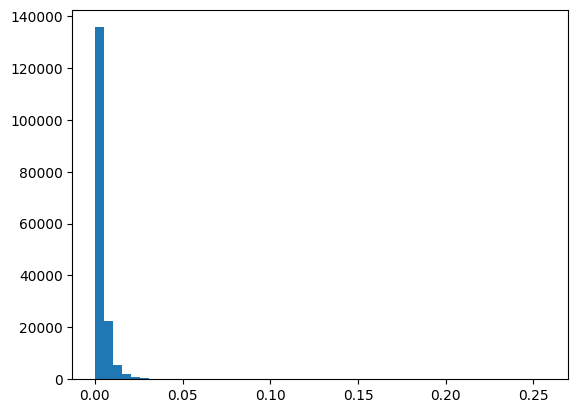

Tiempos de espera por status
count    156853.000000
mean          0.003332
std           0.006310
min           0.000012
25%           0.000509
50%           0.001806
75%           0.004062
max           0.257025
Name: Tiempo_espera, dtype: float64
count    11390.000000
mean         0.005578
std          0.009518
min          0.000012
25%          0.001319
50%          0.003067
75%          0.006516
max          0.189942
Name: Tiempo_espera, dtype: float64


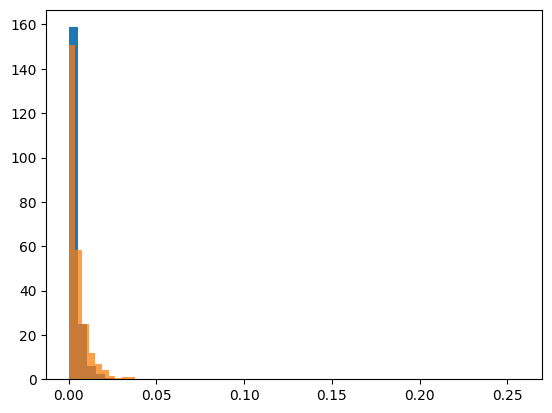

---------------------------------------
Tienda_AG
Tiempos de espera
count    268596.000000
mean          0.002611
std           0.008060
min           0.000012
25%           0.000347
50%           0.001435
75%           0.003310
max           0.348021
Name: Tiempo_espera, dtype: float64


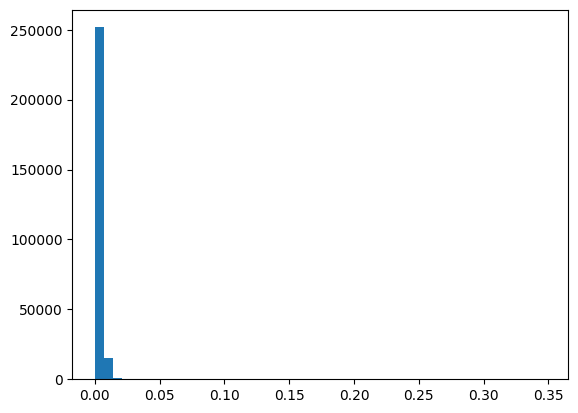

Tiempos de espera por status
count    260315.000000
mean          0.002575
std           0.008123
min           0.000012
25%           0.000336
50%           0.001400
75%           0.003252
max           0.348021
Name: Tiempo_espera, dtype: float64
count    8281.000000
mean        0.003745
std         0.005629
min         0.000012
25%         0.001134
50%         0.002685
75%         0.005058
max         0.200937
Name: Tiempo_espera, dtype: float64


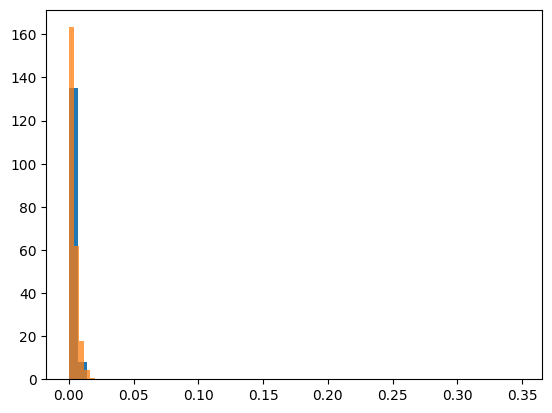

---------------------------------------
Tienda_AH
Tiempos de espera
count    102808.000000
mean          0.005280
std           0.008659
min           0.000012
25%           0.001285
50%           0.003079
75%           0.006574
max           0.294051
Name: Tiempo_espera, dtype: float64


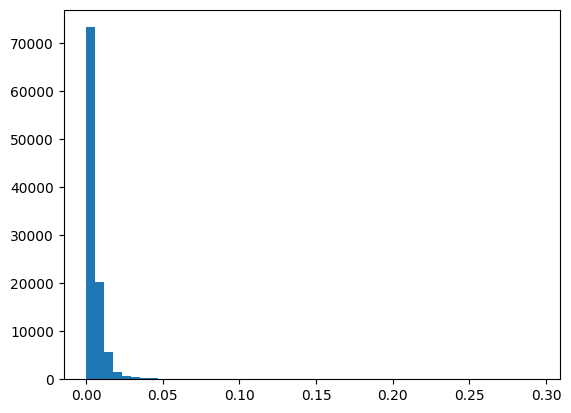

Tiempos de espera por status
count    93237.000000
mean         0.004971
std          0.008029
min          0.000012
25%          0.001192
50%          0.002928
75%          0.006285
max          0.260602
Name: Tiempo_espera, dtype: float64
count    9571.000000
mean        0.008291
std         0.012943
min         0.000012
25%         0.002338
50%         0.005058
75%         0.009578
max         0.294051
Name: Tiempo_espera, dtype: float64


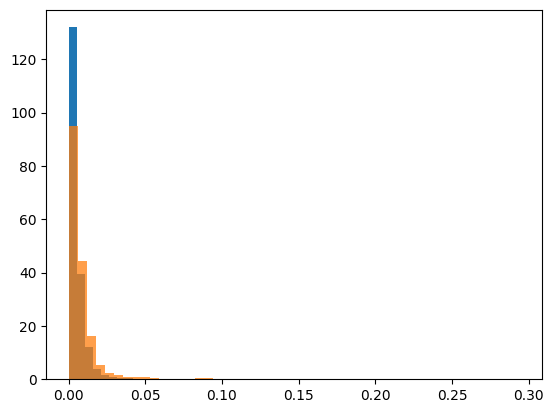

---------------------------------------
Tienda_AI
Tiempos de espera
count    219140.000000
mean          0.002325
std           0.004601
min           0.000012
25%           0.000058
50%           0.001019
75%           0.003009
max           0.378773
Name: Tiempo_espera, dtype: float64


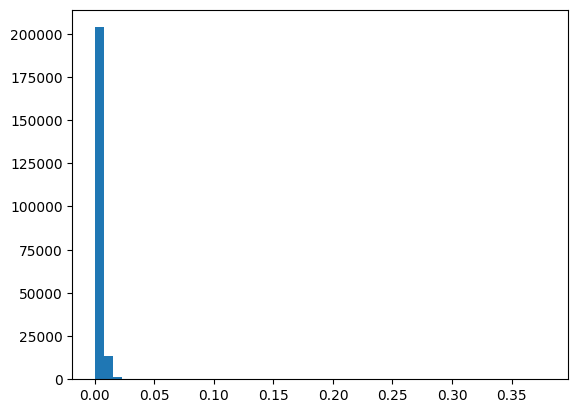

Tiempos de espera por status
count    212121.000000
mean          0.002252
std           0.004303
min           0.000012
25%           0.000058
50%           0.000995
75%           0.002951
max           0.378773
Name: Tiempo_espera, dtype: float64
count    7019.000000
mean        0.004535
std         0.009811
min         0.000012
25%         0.000602
50%         0.002083
75%         0.005405
max         0.242141
Name: Tiempo_espera, dtype: float64


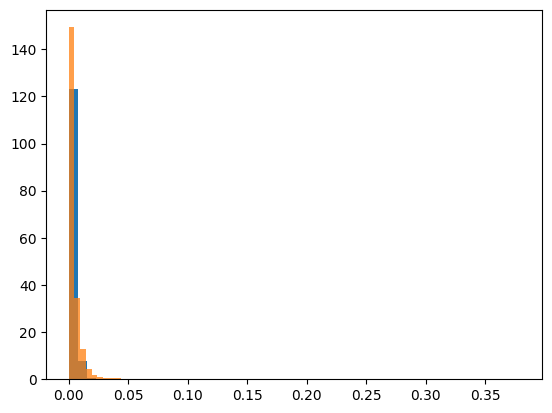

---------------------------------------
Tienda_AJ
Tiempos de espera
count    194822.000000
mean          0.001344
std           0.002885
min           0.000012
25%           0.000046
50%           0.000509
75%           0.001771
max           0.282604
Name: Tiempo_espera, dtype: float64


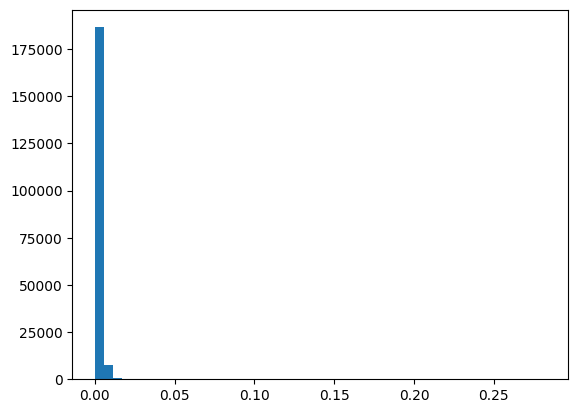

Tiempos de espera por status
count    193465.000000
mean          0.001332
std           0.002875
min           0.000012
25%           0.000046
50%           0.000498
75%           0.001759
max           0.282604
Name: Tiempo_espera, dtype: float64
count    1357.000000
mean        0.002948
std         0.003743
min         0.000012
25%         0.000694
50%         0.001863
75%         0.003808
max         0.040671
Name: Tiempo_espera, dtype: float64


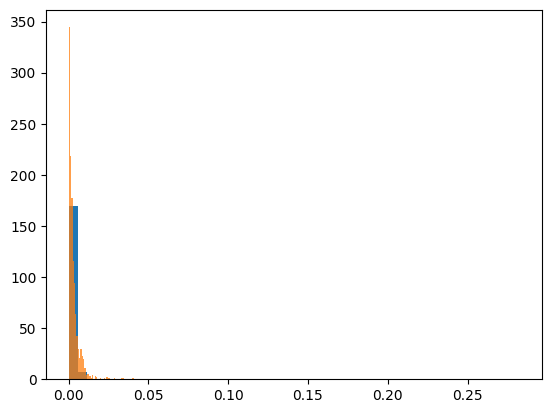

---------------------------------------
Tienda_AK
Tiempos de espera
count    128923.000000
mean          0.004915
std           0.015360
min           0.000012
25%           0.000243
50%           0.001505
75%           0.003947
max           0.343762
Name: Tiempo_espera, dtype: float64


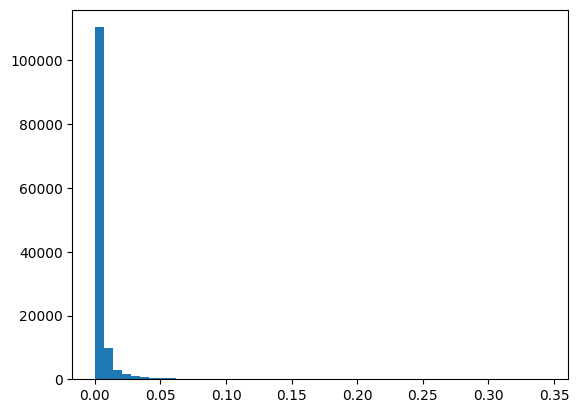

Tiempos de espera por status
count    121020.000000
mean          0.004814
std           0.015576
min           0.000012
25%           0.000197
50%           0.001412
75%           0.003762
max           0.343762
Name: Tiempo_espera, dtype: float64
count    7903.000000
mean        0.006457
std         0.011458
min         0.000012
25%         0.001319
50%         0.002940
75%         0.006944
max         0.272975
Name: Tiempo_espera, dtype: float64


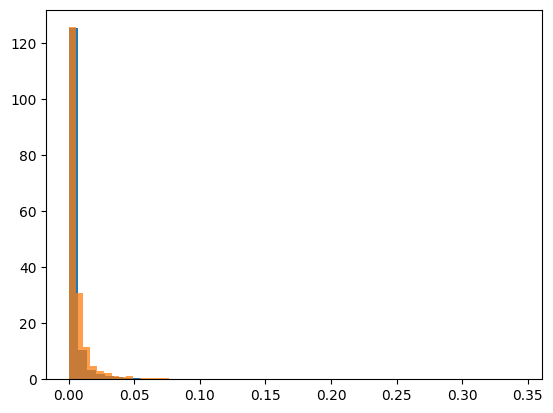

---------------------------------------
Tienda_AA
Tiempos de espera
count    108916.000000
mean          0.002663
std           0.007283
min           0.000012
25%           0.000081
50%           0.001204
75%           0.003252
max           0.294931
Name: Tiempo_espera, dtype: float64


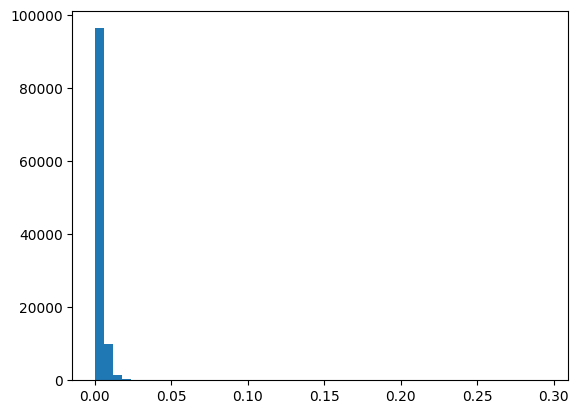

Tiempos de espera por status
count    105185.000000
mean          0.002574
std           0.007246
min           0.000012
25%           0.000069
50%           0.001146
75%           0.003148
max           0.294931
Name: Tiempo_espera, dtype: float64
count    3731.000000
mean        0.005185
std         0.007852
min         0.000012
25%         0.001412
50%         0.003241
75%         0.006632
max         0.232870
Name: Tiempo_espera, dtype: float64


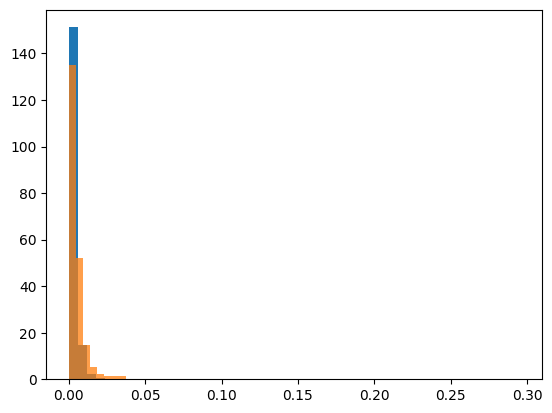

---------------------------------------
Tienda_AL
Tiempos de espera
count    202304.000000
mean          0.014474
std           0.012751
min           0.000012
25%           0.005139
50%           0.011597
75%           0.020775
max           0.366956
Name: Tiempo_espera, dtype: float64


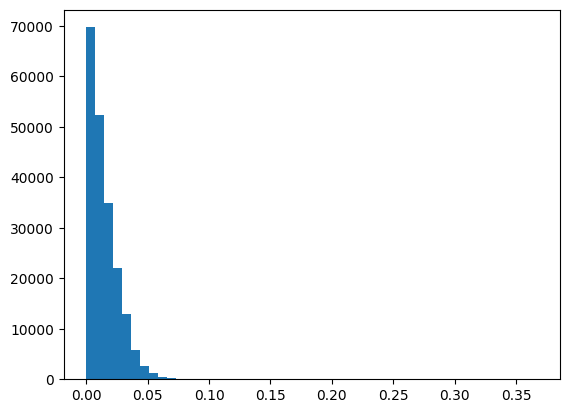

Tiempos de espera por status
count    196585.000000
mean          0.014354
std           0.012705
min           0.000012
25%           0.005081
50%           0.011493
75%           0.020556
max           0.366956
Name: Tiempo_espera, dtype: float64
count    5719.000000
mean        0.018596
std         0.013627
min         0.000012
25%         0.008084
50%         0.016412
75%         0.026655
max         0.290174
Name: Tiempo_espera, dtype: float64


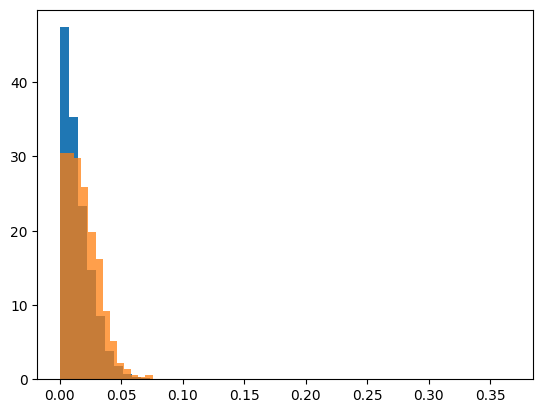

---------------------------------------
Tienda_AM
Tiempos de espera
count    216492.000000
mean          0.003599
std           0.007343
min           0.000012
25%           0.000625
50%           0.002164
75%           0.004838
max           0.369051
Name: Tiempo_espera, dtype: float64


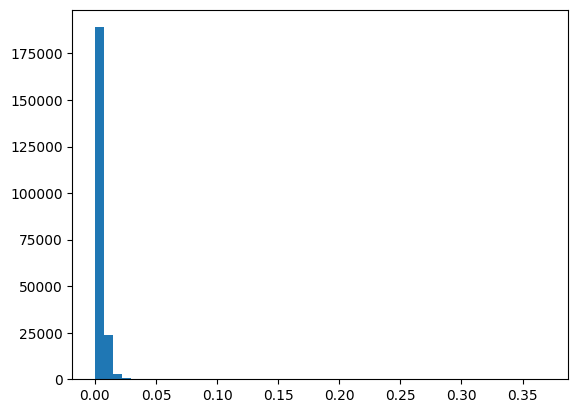

Tiempos de espera por status
count    202812.000000
mean          0.003384
std           0.007009
min           0.000012
25%           0.000579
50%           0.002049
75%           0.004572
max           0.369051
Name: Tiempo_espera, dtype: float64
count    13680.000000
mean         0.006780
std          0.010686
min          0.000012
25%          0.002118
50%          0.004861
75%          0.008637
max          0.362523
Name: Tiempo_espera, dtype: float64


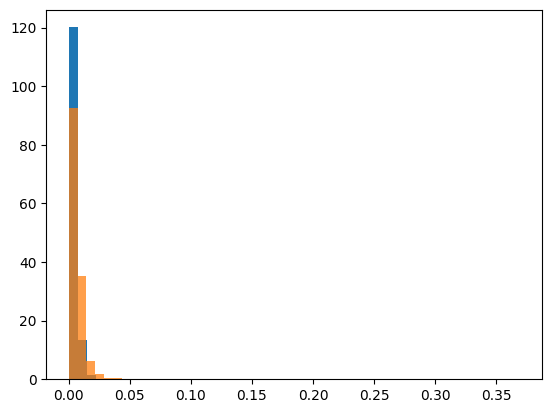

---------------------------------------
Tienda_AN
Tiempos de espera
count    181276.000000
mean          0.002471
std           0.008662
min           0.000012
25%           0.000058
50%           0.001030
75%           0.002616
max           0.500382
Name: Tiempo_espera, dtype: float64


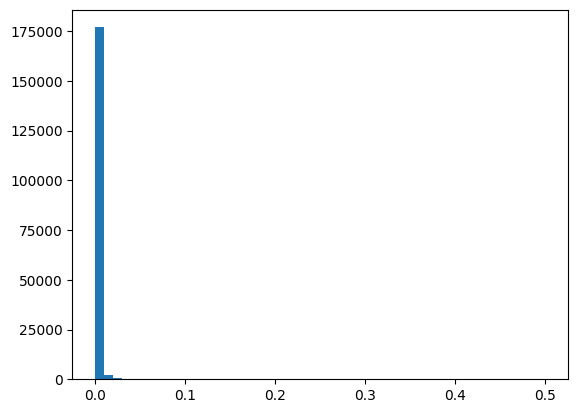

Tiempos de espera por status
count    175365.000000
mean          0.002441
std           0.008726
min           0.000012
25%           0.000058
50%           0.001007
75%           0.002569
max           0.500382
Name: Tiempo_espera, dtype: float64
count    5911.000000
mean        0.003362
std         0.006394
min         0.000012
25%         0.000556
50%         0.001968
75%         0.004132
max         0.183600
Name: Tiempo_espera, dtype: float64


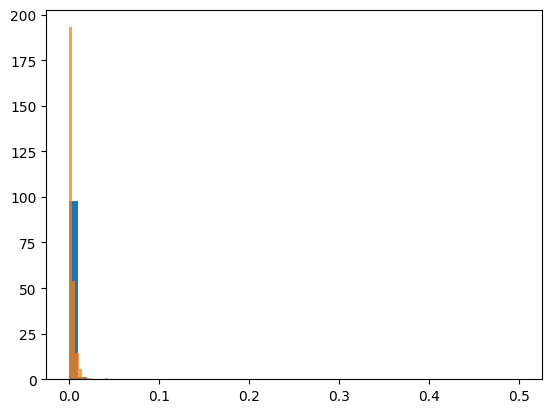

---------------------------------------
Tienda_AO
Tiempos de espera
count    218678.000000
mean          0.001714
std           0.002892
min           0.000012
25%           0.000185
50%           0.001042
75%           0.002350
max           0.176956
Name: Tiempo_espera, dtype: float64


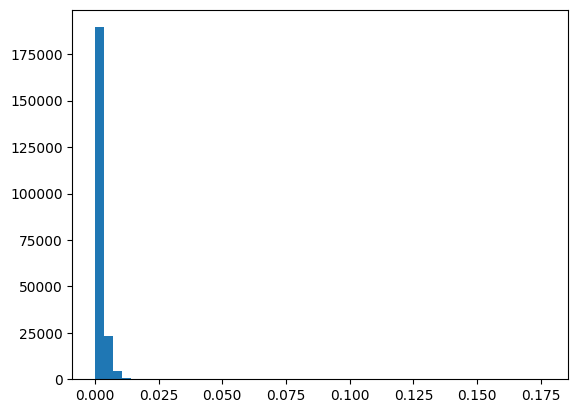

Tiempos de espera por status
count    213018.000000
mean          0.001660
std           0.002594
min           0.000012
25%           0.000174
50%           0.001019
75%           0.002315
max           0.174815
Name: Tiempo_espera, dtype: float64
count    5660.000000
mean        0.003732
std         0.008108
min         0.000012
25%         0.000810
50%         0.002049
75%         0.004158
max         0.176956
Name: Tiempo_espera, dtype: float64


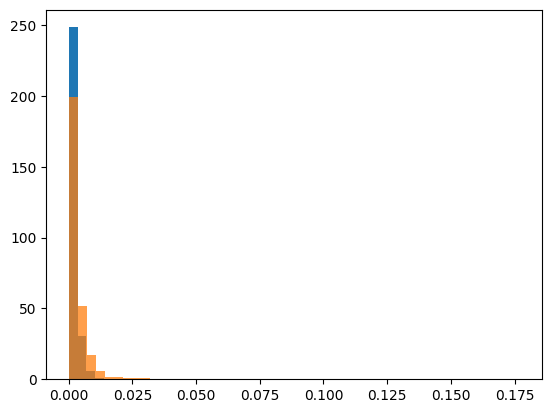

---------------------------------------
Tienda_AP
Tiempos de espera
count    201080.000000
mean          0.001641
std           0.003957
min           0.000012
25%           0.000046
50%           0.000475
75%           0.001956
max           0.361944
Name: Tiempo_espera, dtype: float64


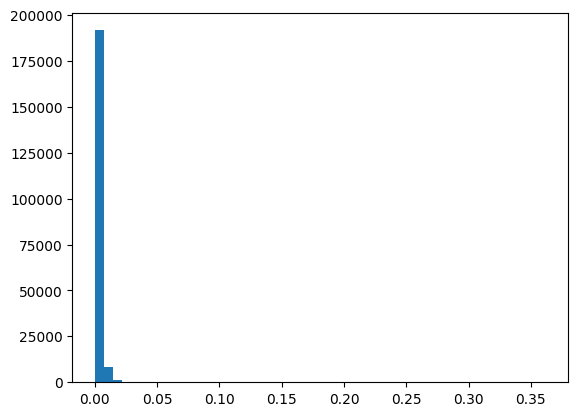

Tiempos de espera por status
count    191983.000000
mean          0.001527
std           0.003441
min           0.000012
25%           0.000035
50%           0.000428
75%           0.001852
max           0.350104
Name: Tiempo_espera, dtype: float64
count    9097.000000
mean        0.004062
std         0.009492
min         0.000012
25%         0.000359
50%         0.001736
75%         0.005012
max         0.361944
Name: Tiempo_espera, dtype: float64


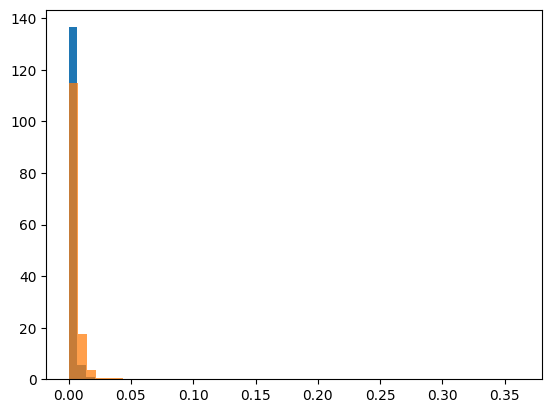

---------------------------------------
Tienda_AQ
Tiempos de espera
count    197785.000000
mean          0.005135
std           0.007111
min           0.000012
25%           0.000995
50%           0.003148
75%           0.007315
max           0.303484
Name: Tiempo_espera, dtype: float64


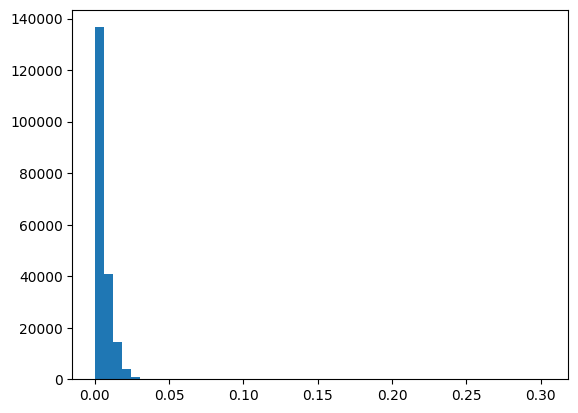

Tiempos de espera por status
count    187581.000000
mean          0.004813
std           0.005718
min           0.000012
25%           0.000949
50%           0.003021
75%           0.007037
max           0.303484
Name: Tiempo_espera, dtype: float64
count    10204.000000
mean         0.011047
std          0.018502
min          0.000012
25%          0.002616
50%          0.006956
75%          0.013035
max          0.251493
Name: Tiempo_espera, dtype: float64


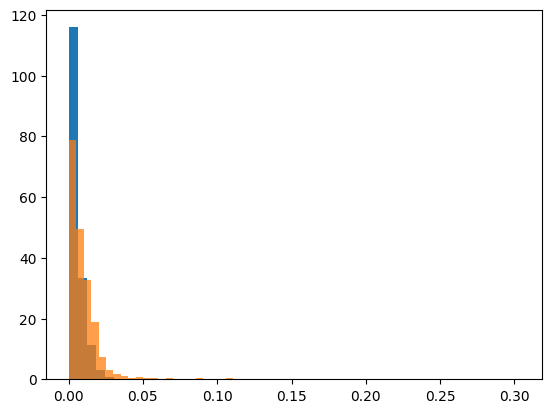

---------------------------------------
Tienda_AX
Tiempos de espera
count    246971.000000
mean          0.001465
std           0.006799
min           0.000012
25%           0.000035
50%           0.000417
75%           0.001516
max           0.286690
Name: Tiempo_espera, dtype: float64


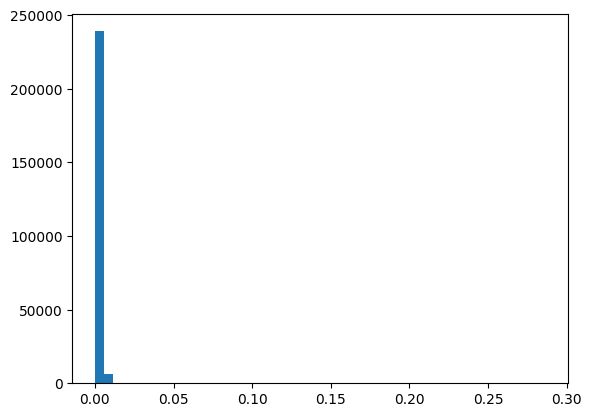

Tiempos de espera por status
count    246631.000000
mean          0.001462
std           0.006781
min           0.000012
25%           0.000035
50%           0.000417
75%           0.001516
max           0.286690
Name: Tiempo_espera, dtype: float64
count    340.000000
mean       0.003957
std        0.014553
min        0.000012
25%        0.000394
50%        0.001545
75%        0.003672
max        0.170127
Name: Tiempo_espera, dtype: float64


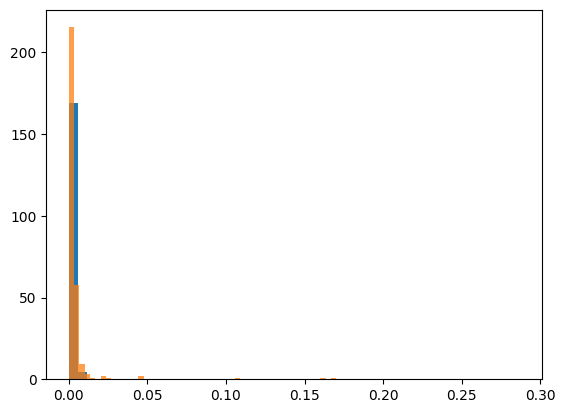

---------------------------------------
Tienda_AD
Tiempos de espera
count    178311.000000
mean          0.003966
std           0.005578
min           0.000012
25%           0.000683
50%           0.002303
75%           0.005365
max           0.290567
Name: Tiempo_espera, dtype: float64


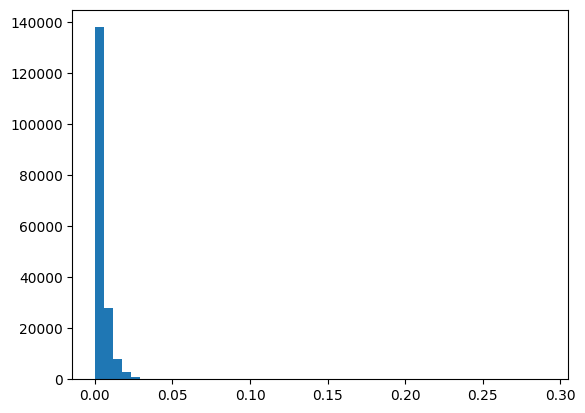

Tiempos de espera por status
count    170730.000000
mean          0.003761
std           0.005326
min           0.000012
25%           0.000637
50%           0.002199
75%           0.005127
max           0.290567
Name: Tiempo_espera, dtype: float64
count    7581.000000
mean        0.008566
std         0.008418
min         0.000012
25%         0.002604
50%         0.006181
75%         0.012245
max         0.130058
Name: Tiempo_espera, dtype: float64


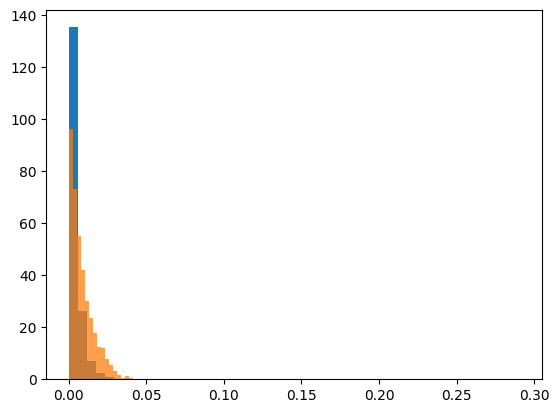

---------------------------------------
Tienda_AY
Tiempos de espera
count    190644.000000
mean          0.001982
std           0.010393
min           0.000012
25%           0.000046
50%           0.000521
75%           0.001644
max           0.361852
Name: Tiempo_espera, dtype: float64


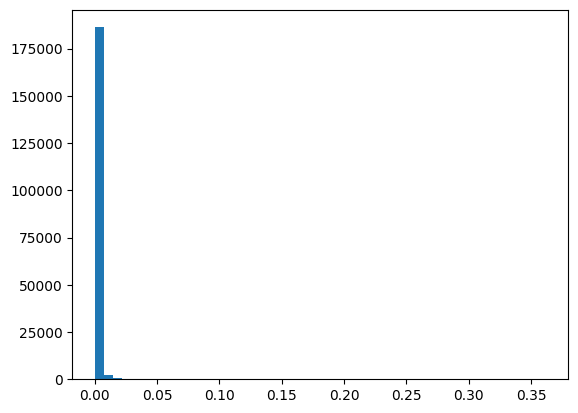

Tiempos de espera por status
count    189065.000000
mean          0.001970
std           0.010360
min           0.000012
25%           0.000046
50%           0.000521
75%           0.001632
max           0.361852
Name: Tiempo_espera, dtype: float64
count    1579.000000
mean        0.003414
std         0.013646
min         0.000012
25%         0.000255
50%         0.001181
75%         0.002679
max         0.359051
Name: Tiempo_espera, dtype: float64


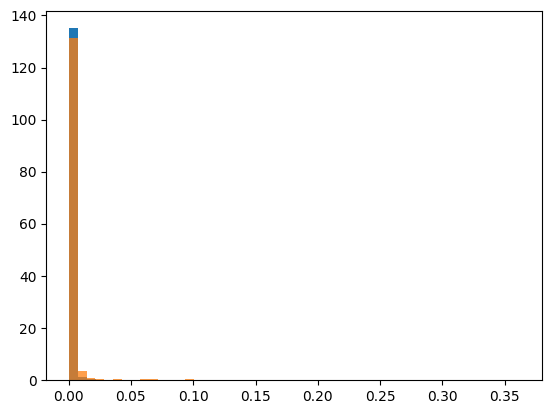

---------------------------------------
Tienda_AZ
Tiempos de espera
count    198977.000000
mean          0.001791
std           0.003635
min           0.000012
25%           0.000046
50%           0.000833
75%           0.002396
max           0.313692
Name: Tiempo_espera, dtype: float64


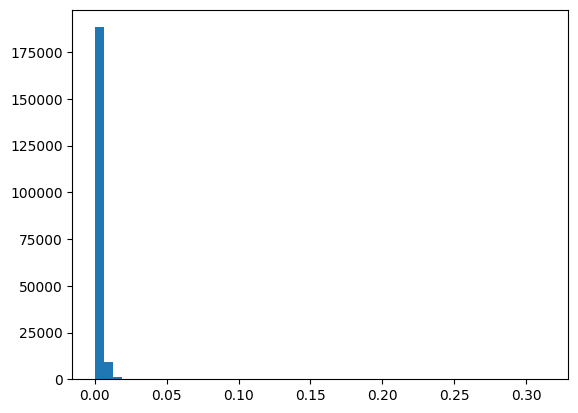

Tiempos de espera por status
count    194268.000000
mean          0.001723
std           0.003296
min           0.000012
25%           0.000046
50%           0.000799
75%           0.002338
max           0.313692
Name: Tiempo_espera, dtype: float64
count    4709.000000
mean        0.004621
std         0.010095
min         0.000012
25%         0.000891
50%         0.002604
75%         0.005660
max         0.245104
Name: Tiempo_espera, dtype: float64


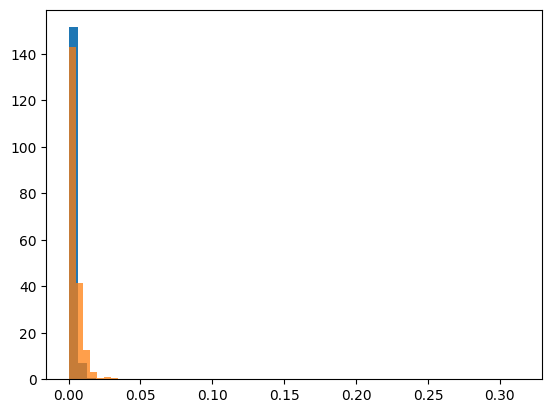

---------------------------------------
Tienda_BA
Tiempos de espera
count    225446.000000
mean          0.000919
std           0.003318
min           0.000012
25%           0.000035
50%           0.000208
75%           0.001100
max           0.306250
Name: Tiempo_espera, dtype: float64


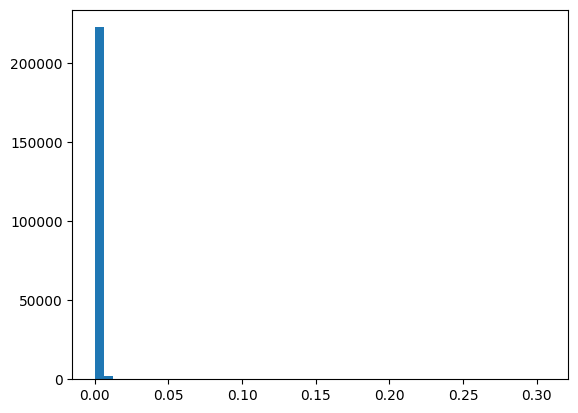

Tiempos de espera por status
count    220245.000000
mean          0.000889
std           0.003131
min           0.000012
25%           0.000035
50%           0.000197
75%           0.001076
max           0.293241
Name: Tiempo_espera, dtype: float64
count    5201.000000
mean        0.002175
std         0.007773
min         0.000012
25%         0.000058
50%         0.000775
75%         0.002130
max         0.306250
Name: Tiempo_espera, dtype: float64


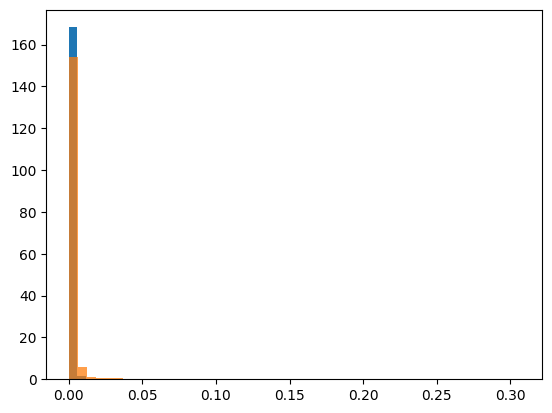

---------------------------------------
Tienda_BB
Tiempos de espera
count    141788.000000
mean          0.004557
std           0.008682
min           0.000012
25%           0.000845
50%           0.002604
75%           0.005891
max           0.366852
Name: Tiempo_espera, dtype: float64


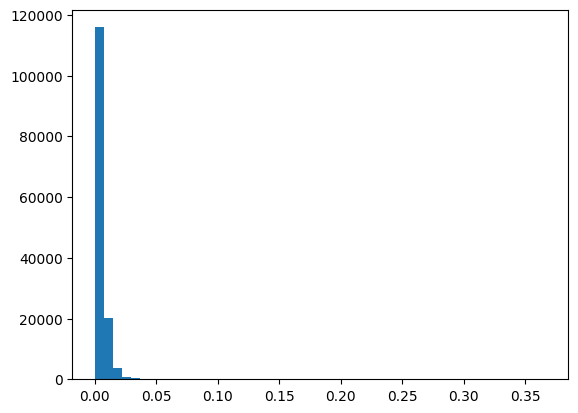

Tiempos de espera por status
count    134446.000000
mean          0.004406
std           0.008536
min           0.000012
25%           0.000787
50%           0.002512
75%           0.005694
max           0.366852
Name: Tiempo_espera, dtype: float64
count    7342.000000
mean        0.007329
std         0.010648
min         0.000012
25%         0.002222
50%         0.005069
75%         0.009282
max         0.241574
Name: Tiempo_espera, dtype: float64


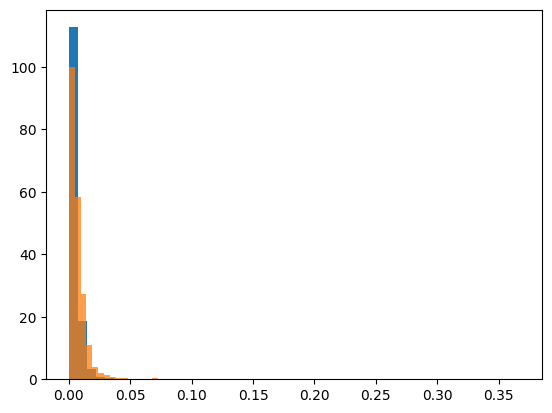

---------------------------------------
Tienda_BC
Tiempos de espera
count    164584.000000
mean          0.003620
std           0.008745
min           0.000012
25%           0.000428
50%           0.001817
75%           0.004271
max           0.272222
Name: Tiempo_espera, dtype: float64


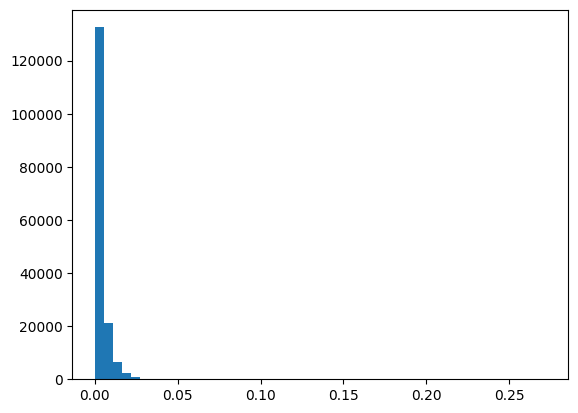

Tiempos de espera por status
count    154952.000000
mean          0.003417
std           0.008068
min           0.000012
25%           0.000394
50%           0.001736
75%           0.004063
max           0.266875
Name: Tiempo_espera, dtype: float64
count    9632.000000
mean        0.006887
std         0.015753
min         0.000012
25%         0.001215
50%         0.003275
75%         0.008093
max         0.272222
Name: Tiempo_espera, dtype: float64


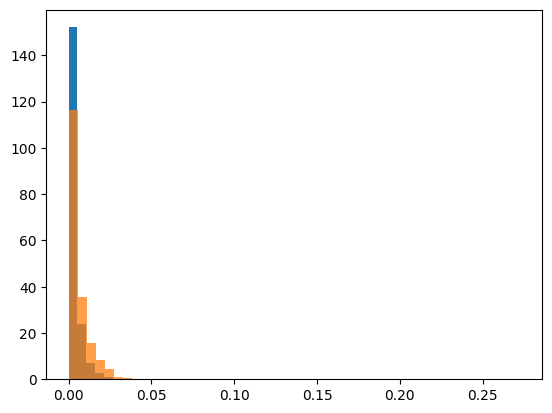

---------------------------------------
Tienda_BD
Tiempos de espera
count    257702.000000
mean          0.002874
std           0.004070
min           0.000012
25%           0.000521
50%           0.001782
75%           0.003993
max           0.349780
Name: Tiempo_espera, dtype: float64


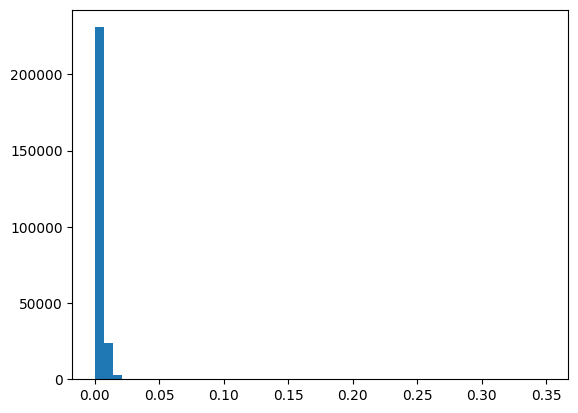

Tiempos de espera por status
count    248031.000000
mean          0.002734
std           0.003668
min           0.000012
25%           0.000498
50%           0.001713
75%           0.003819
max           0.349780
Name: Tiempo_espera, dtype: float64
count    9671.000000
mean        0.006479
std         0.009106
min         0.000012
25%         0.002269
50%         0.005185
75%         0.008837
max         0.309722
Name: Tiempo_espera, dtype: float64


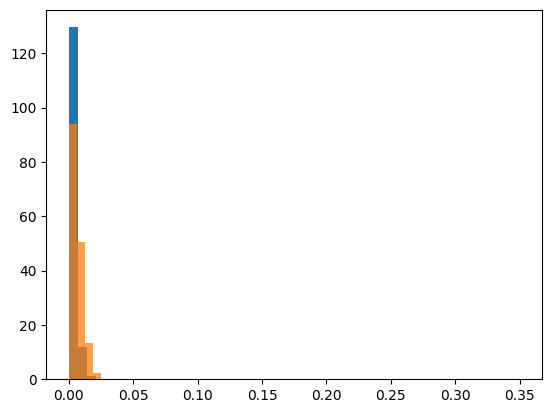

---------------------------------------
Tienda_BE
Tiempos de espera
count    232531.000000
mean          0.003381
std           0.005868
min           0.000012
25%           0.000498
50%           0.001979
75%           0.004653
max           0.331898
Name: Tiempo_espera, dtype: float64


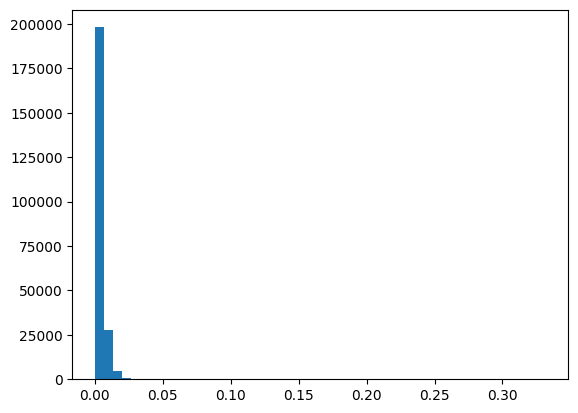

Tiempos de espera por status
count    227430.000000
mean          0.003267
std           0.005172
min           0.000012
25%           0.000486
50%           0.001944
75%           0.004560
max           0.331898
Name: Tiempo_espera, dtype: float64
count    5101.000000
mean        0.008449
std         0.018736
min         0.000012
25%         0.001968
50%         0.004537
75%         0.008403
max         0.232558
Name: Tiempo_espera, dtype: float64


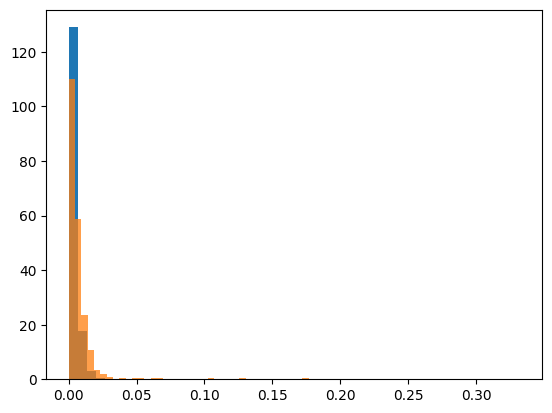

---------------------------------------


In [30]:
EDA(retail_por_tienda)

## Prueba hipótesis

Antes que nada, a pesar de que parezca obvio, sería buena práctica analizar si realmente existe una diferencia entre los tiempos de espera de clientes que fueron atendidos con los que se fueron antes de ser atendidos. Para esto usaremos prueba de permutación para diferencia de medianas.

H0: mediana2 - mediana1 = 0 \
H1: mediana2 - mediana1 != 0

In [31]:
valores_p = []
for tienda, conjunto_datos in retail_por_tienda.items():
    B = 100
    obs = (conjunto_datos[conjunto_datos['Status'] == 'Ausente']['Tiempo_espera'].median() -
           conjunto_datos[conjunto_datos['Status'] == 'Atendido']['Tiempo_espera'].median())
    diferencias_medianas = []

    for _ in range(B):
        etiquetas = np.random.permutation(conjunto_datos["Status"])
        diferencias_medianas.append(conjunto_datos[etiquetas == "Ausente"]["Tiempo_espera"].median() -
                                  conjunto_datos[etiquetas == "Atendido"]["Tiempo_espera"].median())

    valores_p.append(((np.sum(np.array(diferencias_medianas) >= obs)) + 1) / (B + 1))


Un nivel de significancia de 5% parece razonable al no haber una necesidad de ser conservador.

In [32]:
print(np.sum(np.array(valores_p) <= 0.05))

50


En todos los casos, tenemos evidencia muy fuerte en contra de la hipotesis nula, es decir, tenemos suficiente evidencia estadística para creer que, la mediana de los tiempos de espera de las personas que se ausentaron es mayor que el de las personas que fueron atendidas.

## Estimación de parámetros y distribuciones

### Tiempos de espera

In [33]:
muestra = retail['Tiempo_espera'].sample(frac=0.1)

In [34]:
datos_transformados = np.sqrt(muestra)

**Exponencial**

In [35]:
params_expon = expon.fit(muestra, floc=0)
print(params_expon)

(0.0, 0.043628968231254873)


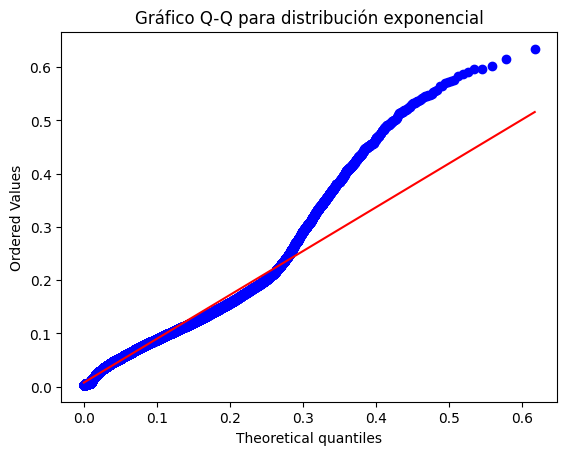

In [36]:
probplot(muestra, dist='expon', sparams=params_expon, plot=plt)
plt.title("Gráfico Q-Q para distribución exponencial")
plt.show()

In [37]:
resultado = kstest(muestra, 'expon', args=params_expon)
print(f"Valor p: {resultado.pvalue}")

Valor p: 0.0


**Weibull**

In [38]:
params_weibull = weibull_min.fit(muestra, floc=0)
print(params_weibull)

(np.float64(0.6022739459269943), 0, np.float64(0.002155415809251983))


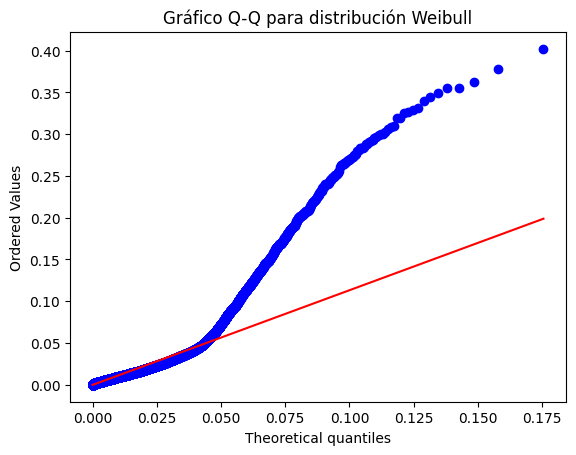

In [39]:
probplot(muestra, dist='weibull_min', sparams=params_weibull, plot=plt)
plt.title("Gráfico Q-Q para distribución Weibull")
plt.show()

**Gamma**

In [40]:
params_gamma = gamma.fit(muestra, floc=0)
print(params_gamma)

(0.4699960433624733, 0, np.float64(0.006862428945259583))


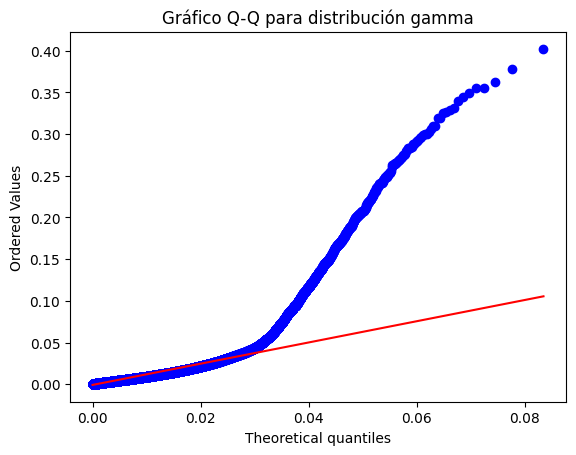

In [41]:
probplot(muestra, dist='gamma', sparams=params_gamma, plot=plt)
plt.title("Gráfico Q-Q para distribución gamma")
plt.show()

In [42]:
resultado = kstest(muestra, 'gamma', args=params_gamma)
print(f"Valor p: {resultado.pvalue}")

Valor p: 0.0


**Lognorm**

In [43]:
params_lognorm = lognorm.fit(muestra, floc=0)
print(params_lognorm)

(np.float64(2.063401643287202), 0, np.float64(0.000824025878220897))


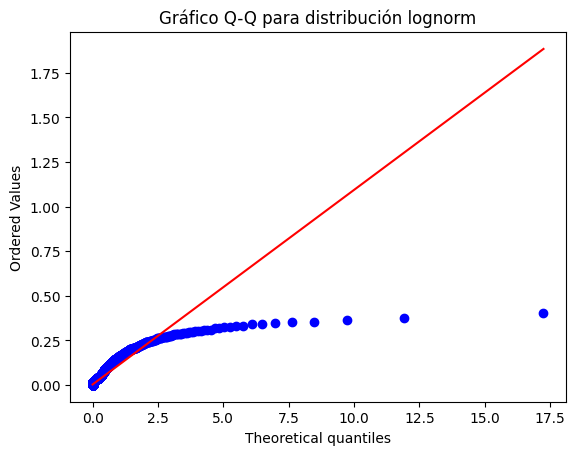

In [44]:
probplot(muestra, dist='lognorm', sparams=params_lognorm, plot=plt)
plt.title("Gráfico Q-Q para distribución lognorm")
plt.show()

In [45]:
resultado = kstest(muestra, 'pareto', args=params_lognorm)
print(f"Valor p: {resultado.pvalue}")

Valor p: 0.0


**Pareto**

In [46]:
params_pareto = lognorm.fit(muestra, floc=0)
print(params_pareto)

(np.float64(2.063401643287202), 0, np.float64(0.000824025878220897))


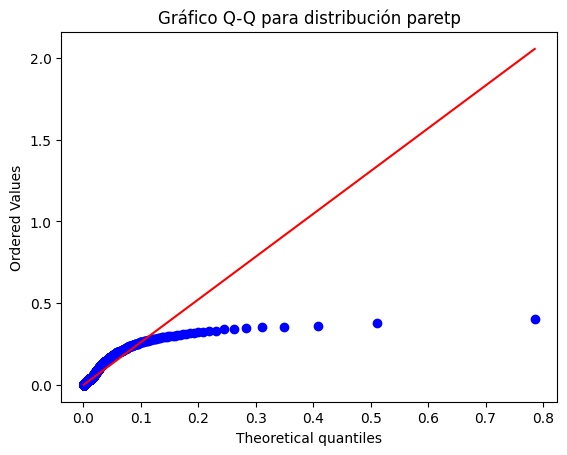

In [47]:
probplot(muestra, dist='pareto', sparams=params_pareto, plot=plt)
plt.title("Gráfico Q-Q para distribución paretp")
plt.show()

**Distribución con menor SSE**

In [48]:
dfit = distfit()
dfit.fit_transform(muestra)


[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 8.77133e+06] [loc=0.003 scale=0.007]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 6.76526e+06] [loc=0.000 scale=0.003]
[distfit] >INFO> [pareto    ] [1.17 sec] [RSS: 5.10133e+06] [loc=-0.001 scale=0.001]
[distfit] >INFO> [dweibull  ] [56.2 sec] [RSS: 7.77328e+06] [loc=0.001 scale=0.002]
[distfit] >INFO> [t         ] [77.3 sec] [RSS: 7.63288e+06] [loc=0.001 scale=0.001]
[distfit] >INFO> [genextreme] [60.6 sec] [RSS: 2.67565e+06] [loc=0.000 scale=0.001]
[distfit] >INFO> [gamma     ] [23.6 sec] [RSS: 6.04679e+06] [loc=0.000 scale=1.259]
[distfit] >INFO> [lognorm   ] [2.90 sec] [RSS: 2.38826e+06] [loc=0.000 scale=0.000]
[distfit] >INFO> [beta      ] [52.0 sec] [RSS: 1.38814e+06] [loc=0.000 scale=0.603]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 9.73749e+06] [loc=0.000 scale=0.402]
[distfit] >INFO> [loggamma  ] [16.9 sec] [RSS: 8.84933e+06] [loc=-1.739 scale=0.251]
[distfit] >INFO> [norm    

{'model': {'name': 'beta',
  'score': 1388143.8134248245,
  'loc': 1.1574074073983363e-05,
  'scale': 0.6034590134596867,
  'arg': (np.float64(0.29671648049101607), np.float64(114.88301541675239)),
  'params': (np.float64(0.29671648049101607),
   np.float64(114.88301541675239),
   np.float64(1.1574074073983363e-05),
   np.float64(0.6034590134596867)),
  'model': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x1cc3d0df250>,
  'bootstrap_score': 0,
  'bootstrap_pass': None,
  'color': '#e41a1c',
  'CII_min_alpha': np.float64(1.1725243355331834e-05),
  'CII_max_alpha': np.float64(0.007145971722790619)},
 'summary':           name           score       loc     scale  \
 0         beta  1388143.813425  0.000012  0.603459   
 1      lognorm  2388258.646558  0.000012  0.000211   
 2   genextreme  2675648.220508  0.000312  0.000636   
 3       pareto  5101327.938403  -0.00141  0.001421   
 4        gamma  6046787.512013  0.000012  1.258685   
 5        expon  6765262.194526  0.000

In [49]:
print(dfit.model)

{'name': 'beta', 'score': 1388143.8134248245, 'loc': 1.1574074073983363e-05, 'scale': 0.6034590134596867, 'arg': (np.float64(0.29671648049101607), np.float64(114.88301541675239)), 'params': (np.float64(0.29671648049101607), np.float64(114.88301541675239), np.float64(1.1574074073983363e-05), np.float64(0.6034590134596867)), 'model': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001CC3D0DF250>, 'bootstrap_score': 0, 'bootstrap_pass': None, 'color': '#e41a1c', 'CII_min_alpha': np.float64(1.1725243355331834e-05), 'CII_max_alpha': np.float64(0.007145971722790619)}


[distfit] >INFO> Create pdf plot for the parametric method.
[distfit] >INFO> Estimated distribution: Beta(loc:0.000012, scale:0.603459)


(<Figure size 2000x1500 with 1 Axes>,
 <Axes: title={'center': '\nbeta(a=0.296716, b=114.883, loc=1.15741e-05, scale=0.603459)'}, xlabel='Values', ylabel='Frequency'>)

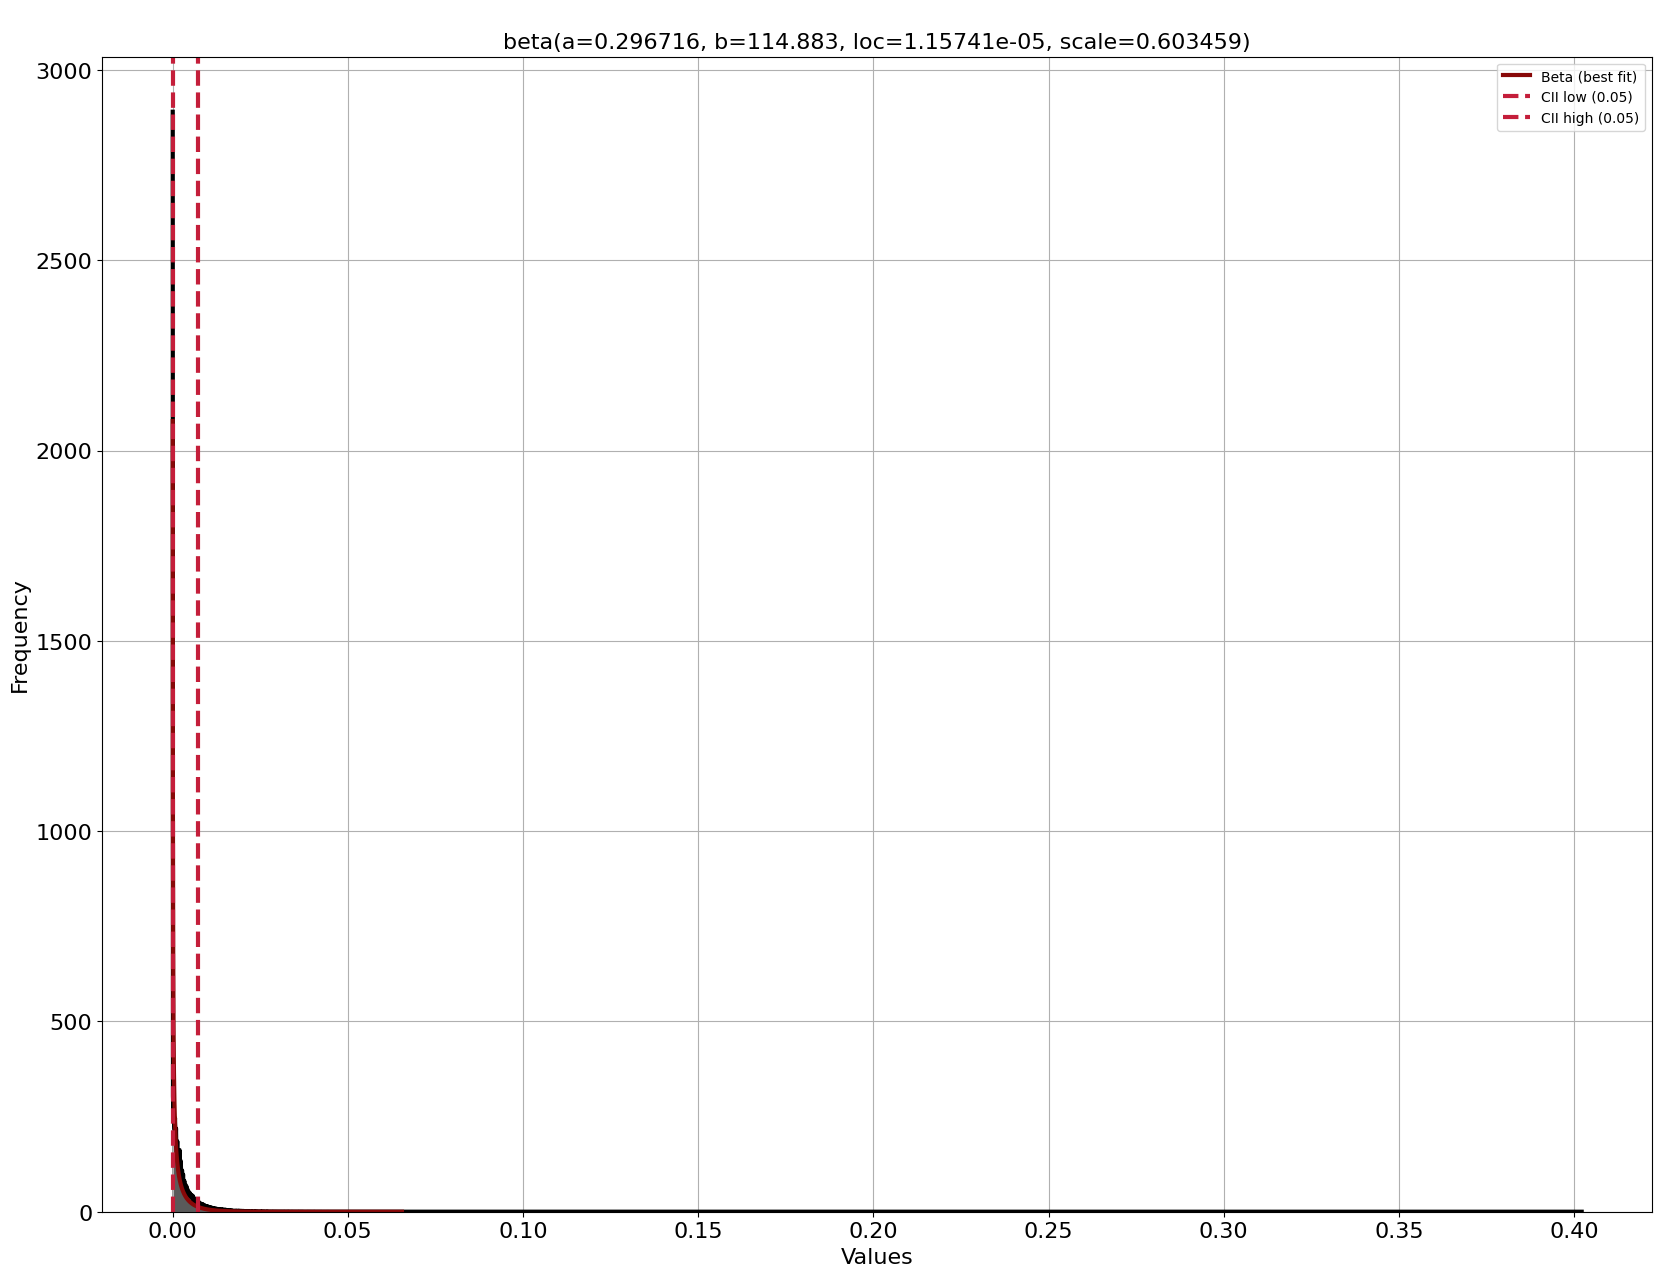

In [50]:
dfit.plot()

In [66]:
probplot(muestra, dist='lognorm', sparams=dfit.model['params'], plot=plt)
plt.title("Gráfico Q-Q para distribución lognorm")
plt.show()

TypeError: _parse_args() takes from 2 to 4 positional arguments but 5 were given

Comentario: no se encontro una distribución que se ajuste correctamente a los datos.

**KDE**

Aproximemos la distribucion con KDE.

In [56]:
kde = gaussian_kde(muestra)

In [57]:
X = np.linspace(min(muestra), max(muestra), 1000)  # Rango de valores
densidad = kde(X)

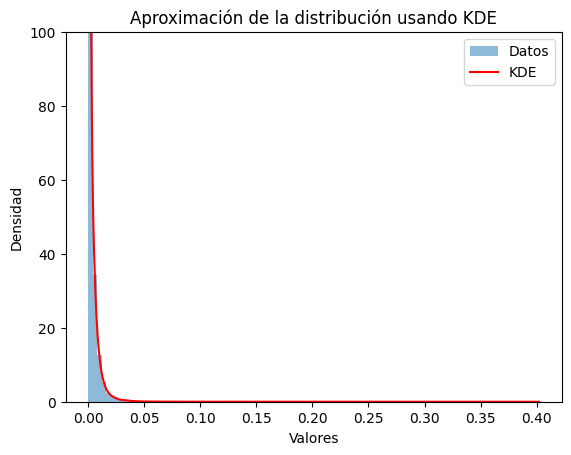

In [62]:
plt.hist(muestra, bins=100, density=True, alpha=0.5, label='Datos')  # Histograma normalizado
plt.plot(X, densidad, label='KDE', color='red')  # Curva de KDE
plt.ylim((0, 100))
plt.xlabel('Valores')
plt.ylabel('Densidad')
plt.title('Aproximación de la distribución usando KDE')
plt.legend()
plt.show()

**Exponencial por tienda**

In [51]:
pvalores = []
for tienda, conjunto_datos in retail_por_tienda.items():
    params_expon = expon.fit(conjunto_datos['Tiempo_espera'], floc=0)
    resultado = kstest(conjunto_datos['Tiempo_espera'], 'expon', args=params_expon)
    pvalores.append(resultado.pvalue)
print(pvalores)

[np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(4.5942259257826e-310), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0)]


In [52]:
np.sum(np.array(pvalores) >= 0.05) / len(pvalores)

np.float64(0.0)

Como se esperaba, los datos no provienen de una exponencial, por lo que, lo más adecuado sería usar métodos como KDE para aproximar la ditribución.

**KDE para tiempos de espera por tienda, dia y número de cajas abiertas**

E: tiempo de espera \
T: tienda \
D: día de la semana \
N: número de cajas abiertas \
P(E | T=t, D=d, N=n)

In [ ]:
dists = dict()
for t in retail['Tienda'].unique():
    for d in retail['Dia_Semana'].unique():
        for n in retail['Numero_cajas'].unique():


## Líneas de espera M/M/s

S: sistemas \
$\lambda$: tasa de legada \
$\mu$: tasa de atención \
$W_S$: tiempo en el sistema $S$ \
$L_S$: cantidad de clientes en el sistema\
Tasa de llegada \
Tasa de servicio

In [95]:
# Diccionarios para almacenar los parámetros estimados
tl_tienda_dia = dict()  # Para almacenar los parámetros de los tiempos entre llegadas
ta_tienda_dia = dict()  # Para almacenar los parámetros de los tiempos de atención

# Variables para contar casos exponenciales y no exponenciales
exponencial_tl = 0  # Contador de casos exponenciales para tiempos entre llegadas
no_exponencial_tl = 0  # Contador de casos no exponenciales para tiempos entre llegadas
exponencial_ta = 0  # Contador de casos exponenciales para tiempos de atención
no_exponencial_ta = 0  # Contador de casos no exponenciales para tiempos de atención

# Umbral para la prueba KS (p-valor)
umbral_ks = 0.05

# Iterar sobre cada tienda
for tienda in retail['Tienda'].unique():
    tl_tienda_dia[tienda] = dict()
    ta_tienda_dia[tienda] = dict()

    # Iterar sobre cada día de la semana
    for dia_semana in retail['Dia_semana'].unique():
        # Filtrar el DataFrame para la tienda y el día actual
        filtro = (retail['Tienda'] == tienda) & (retail['Dia_semana'] == dia_semana)
        datos_filtrados = retail[filtro]

        # Calcular los tiempos de atención (ta)
        if not datos_filtrados.empty:
            tiempos_atencion = datos_filtrados['Hora_salida'] - datos_filtrados['Hora_llamado']
            tiempos_atencion = tiempos_atencion.dropna()  # Eliminar valores faltantes
            tiempos_atencion = tiempos_atencion[tiempos_atencion > 0]  # Eliminar valores no positivos

            if len(tiempos_atencion) > 1:  # Necesitamos al menos 2 puntos para ajustar
                try:
                    # Ajustar la distribución exponencial
                    loc_ta, scale_ta = expon.fit(tiempos_atencion, floc=0)

                    # Realizar la prueba de Kolmogorov-Smirnov
                    ks_statistic, p_valor = kstest(tiempos_atencion, 'expon', args=(loc_ta, scale_ta))

                    # Guardar los parámetros
                    ta_tienda_dia[tienda][dia_semana] = (loc_ta, scale_ta)

                    # Contar si es exponencial o no
                    if p_valor > umbral_ks:
                        exponencial_ta += 1
                    else:
                        no_exponencial_ta += 1
                except:
                    # Si hay un error en el ajuste, no contar
                    pass
        else:
            # Si no hay datos, no contar
            pass

        # Calcular los tiempos entre llegadas (tl)
        if not datos_filtrados.empty:
            tiempos_entre_llegadas = datos_filtrados.sort_values(by='Fecha')['Hora_llegada'].diff().dropna()
            tiempos_entre_llegadas = tiempos_entre_llegadas[tiempos_entre_llegadas > 0]  # Eliminar valores no positivos

            if len(tiempos_entre_llegadas) > 1:  # Necesitamos al menos 2 puntos para ajustar
                try:
                    # Ajustar la distribución exponencial
                    loc_tl, scale_tl = expon.fit(tiempos_entre_llegadas, floc=0)

                    # Realizar la prueba de Kolmogorov-Smirnov
                    ks_statistic, p_valor = kstest(tiempos_entre_llegadas, 'expon', args=(loc_tl, scale_tl))

                    # Guardar los parámetros
                    tl_tienda_dia[tienda][dia_semana] = (loc_tl, scale_tl)

                    # Contar si es exponencial o no
                    if p_valor > umbral_ks:
                        exponencial_tl += 1
                    else:
                        no_exponencial_tl += 1
                except:
                    # Si hay un error en el ajuste, no contar
                    pass
        else:
            # Si no hay datos, no contar
            pass

# Mostrar los resultados
print("\nResumen de casos:")
print(f"Tiempos entre llegadas exponenciales: {exponencial_tl}")
print(f"Tiempos entre llegadas no exponenciales: {no_exponencial_tl}")
print(f"Tiempos de atención exponenciales: {exponencial_ta}")
print(f"Tiempos de atención no exponenciales: {no_exponencial_ta}")

Parámetros de tiempos entre llegadas (tl_tienda_dia): {'Tienda_A': {np.int32(6): (0.0, 0.0032701028451953785), np.int32(0): (0.0, 0.004198954739518462), np.int32(1): (0.0, 0.004657685355705614), np.int32(2): (0.0, 0.005770883620505183), np.int32(3): (0.0, 0.005971923591697273), np.int32(4): (0.0, 0.004885770571191874), np.int32(5): (0.0, 0.003725350877338034)}, 'Tienda_B': {np.int32(6): (0.0, 0.004245712639302235), np.int32(0): (0.0, 0.007292304163251999), np.int32(1): (0.0, 0.00862113722209547), np.int32(2): (0.0, 0.009473710381571956), np.int32(3): (0.0, 0.009351764571653983), np.int32(4): (0.0, 0.008753519980331964), np.int32(5): (0.0, 0.005004927683368511)}, 'Tienda_C': {np.int32(6): (0.0, 0.009738366757472132), np.int32(0): (0.0, 0.015252572350163982), np.int32(1): (0.0, 0.012969620616191412), np.int32(2): (0.0, 0.014733809705518163), np.int32(3): (0.0, 0.01377252115907938), np.int32(4): (0.0, 0.014786056509782305), np.int32(5): (0.0, 0.01510984919518675)}, 'Tienda_D': {np.int32(6

## Líneas de espera G/G/s